# Speeches

In [ ]:
from bs4 import BeautifulSoup
import requests
import pandas as pd
import re
import matplotlib.pyplot as plt
import numpy as np

%matplotlib inline
import seaborn as sns
from   urllib.request import urlopen
from   time   import sleep
import csv

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
import scipy
from scipy.sparse import coo_matrix, hstack
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score
from sklearn.metrics import classification_report

##Scraping

El sitio web cambió a lo largo del tiempo y por eso hacemos un scrapping para los años del 2001 al 2006 y luego otro que va hasta el 2019 para obtener los links de todos los discursos

Scraping de los links de los discursos para el año 2001 al 2006

In [ ]:
df=pd.DataFrame(columns=['link','title','speaker','event','year'])
years=range(2001,2006)
#La página que contiene los links a cada discurso hasta 2006, permite filtrar por año y este filtro direcciona a una url
#que es genérica y solo va cambiando el año en la url
#Bucleo los distintos años para obtener los enlaces a todos los discursos
for year in years:
    speeches_one_year = pd.DataFrame()
#Genero la petición a la página de la fed
    page = requests.get(f'https://www.federalreserve.gov/newsevents/speech/{year}speech.htm')
#Parseo la página web
    soup = BeautifulSoup(page.text, 'html.parser')
#Obtengo el título y el directorio de todos los discursos del año
    title = soup.select(".title")
#Obtengo el orador de todos los discursos del año
    speakers = soup.select(".speaker")
#Obtengo la dirección física de donde ocurrieron todos los discruso del año
    locations = soup.select(".location")
#Bucleo las listas para obtener el link final, el título, el orador, el lugar y el año sin código html
    for i in range(len(title)):
        speeches_one_year.at[i,'link'] = 'https://www.federalreserve.gov'+title[i].find_all('a', href=True)[0]['href']
        speeches_one_year.at[i,'title'] = title[i].text.split('\n')[1]
        speeches_one_year.at[i,'speaker'] = speakers[i].text.split('\n')[1].strip()
        speeches_one_year.at[i,'event'] = locations[i].text.split('\n')[1].strip()
        speeches_one_year.at[i,'year'] = year
    df=df.append(speeches_one_year,ignore_index=True)

Scraping para el año 2006 al 2019 Los discursos presentan una estructura distinta que en el scraping anterior, ahora se devuelve todo en una lista, donde un elemento de la lista dispone de la info del título, orador, link y lugar del discurso

In [ ]:
years=range(2006,2020)
#Bucleo los distintos años para obtener los enlaces a todos los discursos
for year in years:
#En el 2010 cambia el formato del link cuando se filtra el año que se quiere scrapear
    if year > 2010:
        page = requests.get(f'https://www.federalreserve.gov/newsevents/speech/{year}-speeches.htm')
    else:
        page = requests.get(f'https://www.federalreserve.gov/newsevents/speech/{year}speech.htm')
    soup = BeautifulSoup(page.text, 'html.parser')
#Obtengo el "eventlist_event" que contiene la información de orador, nombre de discurso, link y lugar
    events = soup.select(".eventlist__event")
    speeches_one_year = pd.DataFrame()
#Bucleo la lista, para guardar por separado la información, y tenerla en el mismo formato que el scraping anterior
    for i,speech in enumerate(events):
        speeches_one_year.at[i,'link'] = 'https://www.federalreserve.gov'+events[i].find_all('a', href=True)[0]['href']
        speeches_one_year.at[i,'title'] = events[i].text.split('\n')[2]
#Condicional para diferenciar los "Watch Live" y "Video" del resto de discursos, ya que tienen distinto formato
        if events[i].text.split('\n')[3]=='Watch Live' or events[i].text.split('\n')[3]=='Video':
            speeches_one_year.at[i,'speaker'] = events[i].text.split('\n')[4]
            speeches_one_year.at[i,'event'] = events[i].text.split('\n')[5]
        else:
            speeches_one_year.at[i,'speaker'] = events[i].text.split('\n')[3]
            speeches_one_year.at[i,'event'] = events[i].text.split('\n')[4]
        speeches_one_year.at[i,'year'] = year
    df=df.append(speeches_one_year,ignore_index=True)

Obtengo los discursos del link que obtuve previamente. Nuevamente, como cambió la página, debo generar dos scraping

In [ ]:
#Obtengo los discursos del 2001 hasta el 2005 inclusive
#Bucleo todos los links que obtuve previamente
for i in range(len(df)):
#En este scrapping unicamente me fijo en los discursos que van del 2001 al 2005 incluyendo cotas
    if ((df.loc[i,'year']>2000) & (df.loc[i,'year']<2006)):
#Obtengo la página
        page = requests.get(df['link'].iloc[i])
#Parseo el html obtenido
        soup = BeautifulSoup(page.text, 'html.parser')
#Me quedo con el identificador que contiene el discurso
        events = soup.select("table")
#Me fijo la longitud del primer elemento de la lista, si es mayor a 600 ahí está el discurso, si no está en el segundo elemento
        if len(str(events[0].text))>600:
            text_list = [i for i in events[0].text if i]
        else:
            text_list = [i for i in events[1].text if i]
 #Formateo un poco el texto
        text_list = ''.join(text_list)
        text_list = text_list.replace('--', '')
        text_list = text_list.replace('\r', '')
        text_list = text_list.replace('\t', '')
        df.loc[i,'text'] = text_list

In [ ]:
#Scraping para el texto a partir del año 2006 inclusive
#Los siguientes discursos vienen vacios y tiran error, por lo que los omito
black_listed=[493,497]
#Bucleo los años a partir de 2006 y unicamente analizo los discursos que no se encuentren en la black_list
for i in range(1,len(df)):
    if ((df.loc[i,'year']>2005) and (i not in black_listed)):
#Obtengo la página
        page = requests.get(df.loc[i,'link'])
#Parseo el html obtenido
        soup = BeautifulSoup(page.text, 'html.parser')
#Me quedo con el identificador que contiene el discurso
        events = soup.select(".col-md-8")
#Obtengo el discurso
        text_list = events[1].text
#Formateo un poco el texto
        text_list = text_list.replace('\xa0', ' ')
        text_list = text_list.replace('\n', ' ')
        df.loc[i,'text'] = text_list

In [ ]:
df

,link,title,speaker,event,year,text
0,https://www.federalreserve.gov/boarddocs/speec...,Financial stability in emerging markets: What ...,Governor Laurence H. Meyer,At the Center for Strategic and International ...,2001.0,\n\nFinancial Stability in Emerging Markets: W...
1,https://www.federalreserve.gov/boarddocs/speec...,The future of money and of monetary policy,Governor Laurence H. Meyer,"At the Distinguished Lecture Program, Swarthmo...",2001.0,\n\nThe Future of Money and of Monetary Policy...
2,https://www.federalreserve.gov/boarddocs/speec...,Globalization,Chairman Alan Greenspan,"At George Washington University, the Robert P....",2001.0,\n\nIt is a pleasure to be with you this eveni...
3,https://www.federalreserve.gov/boarddocs/speec...,The euro as an international currency,Chairman Alan Greenspan,"Before the Euro 50 Group Roundtable, Washingto...",2001.0,\n\nToday I would like to address some of the ...
4,https://www.federalreserve.gov/boarddocs/speec...,Asset prices and monetary policy,Governor Edward M. Gramlich,At the New Technologies and Monetary Policy In...,2001.0,\n\nAsset Prices and Monetary Policy\n\nDuring...
...,...,...,...,...,...,...
1184,https://www.federalreserve.gov/newsevents/spee...,Welcoming Remarks,Chairman Jerome H. Powell,At Conversation with the Chairman: A Teacher T...,2019.0,Thank you to all the educators who are here w...
1185,https://www.federalreserve.gov/newsevents/spee...,Inviting Participation: The Public's Role in S...,Vice Chairman for Supervision Randal K. Quarles,"To the Council for Economic Education, New Yor...",2019.0,"Thank you, Nan, for that kind introduction, a..."
1186,https://www.federalreserve.gov/newsevents/spee...,Strengthening the Community Reinvestment Act: ...,Governor Lael Brainard,"At ""Research Symposium on the Community Reinve...",2019.0,Thank you all for participating in our Resear...
1187,https://www.federalreserve.gov/newsevents/spee...,Monetary Policy Outlook for 2019,Vice Chairman Richard H. Clarida,At the Money Marketeers of New York University...,2019.0,Happy New Year. I am very glad to be speaking...


Obtenemos más datos relacionados al discurso

In [ ]:
#Obtengo la fecha del discurso
df['date'] = df['link'].str.extract('(\d\d\d\d\d\d\d\d)')
#Obtengo la longitud del discurso
df = df[~df['text'].isna()]
df['text_len'] = df['text'].str.split().apply(len)
#Obtengo la ubicación del discurso
df['location'] = df.event.str.split(', ').apply(lambda x: x[-1])

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys


Corrijo las ubicaciones

In [ ]:
df.loc[df['location']=='D.C. ','location'] = 'D.C.'
df.loc[df['location']=='DC','location'] = 'D.C.'
df.loc[df['location']=='D.C','location'] = 'D.C.'
df.loc[df['location']=='Washington D.C.','location'] = 'D.C.'
df.loc[df['location']=='Washington D.C.Â ','location'] = 'D.C.'
df.loc[df['location']=='New York','location'] = 'New York'
df.loc[df['location']=='N.Y.','location'] = 'New York'
df.loc[df['location']=='New York City','location'] = 'New York'
df.loc[df['location']=='United Kingdom','location'] = 'U.K.'
df.loc[df['location']=='England','location'] = 'U.K.'
df.loc[df['location']=='Scotland','location'] = 'U.K.'
df.loc[df['location']=='London','location'] = 'U.K.'

for i in range(1,len(df)+1):
  if i not in black_listed:
    word = df.loc[i,'location']
    word = word.replace(' (via satellite)', '')
    word = word.replace('(via satellite)', '')
    word = word.replace(' (via prerecorded video)', '')
    word = word.replace('(via prerecorded video)', '')
    word = word.replace(' (via videoconference)', '')
    word = word.replace(' (via video recording)', '')
    word = word.replace('(via videoconference)', '')
    word = word.replace(' (videotaped remarks)', '')
    word = word.replace('(videotaped remarks)', '')
    df.loc[i,'location'] = word.replace(' (via videoconference on February 16)', '')

/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:1763: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(loc, value)


Corrijo nombre de los oradores

In [ ]:
df.loc[df['speaker']=='Chairman  Ben S. Bernanke','speaker'] = 'Chairman Ben S. Bernanke'
df.loc[df['speaker']=='Governor Ben S. Bernanke and Vincent R. Reinhart, Director, Division of Monetary Affairs','speaker'] = 'Governor Ben S. Bernanke'
df.loc[df['speaker']=='Governor Donald L. Kohn and Brian P. Sack, Senior Economist','speaker'] = 'Governor Donald L. Kohn'
df.loc[df['speaker']=='Governor Susan Schmidt Bies','speaker'] = 'Governor Susan S. Bies'
df.loc[df['speaker']=='Vice Chair for Supervision and Chair of the Financial Stability Board Randal K. Quarles','speaker'] = 'Vice Chair for Supervision Randal K. Quarles'
df.loc[df['speaker']=='Vice Chairman for Supervision and Chair of the Financial Stability Board Randal K. Quarles','speaker'] = 'Vice Chair for Supervision Randal K. Quarles'
df.loc[df['speaker']=='Vice Chairman for Supervision Randal K. Quarles','speaker'] = 'Vice Chair for Supervision Randal K. Quarles'
df.loc[df['speaker']=='Vice Chairman Roger W. Ferguson, Jr','speaker'] = 'Vice Chairman Roger W. Ferguson'
df.loc[df['speaker']=='Vice Chairman Roger W. Ferguson, Jr.','speaker'] = 'Vice Chairman Roger W. Ferguson'
df.loc[df['speaker']=='Chair Jerome H. Powell','speaker'] = 'Chairman Jerome H. Powell'
df.loc[df['speaker']=='Vice Chair Richard H. Clarida','speaker'] = 'Vice Chairman Richard H. Clarida'
df = df[df['speaker']!='Brian F. Madigan, Director, Division of Monetary Affairs']

/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:1763: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(loc, value)


In [ ]:
df.head()

,link,title,speaker,event,year,text,date,text_len,location
0,https://www.federalreserve.gov/boarddocs/speec...,Financial stability in emerging markets: What ...,Governor Laurence H. Meyer,At the Center for Strategic and International ...,2001.0,\n\nFinancial Stability in Emerging Markets: W...,20011218,4837,D.C.
1,https://www.federalreserve.gov/boarddocs/speec...,The future of money and of monetary policy,Governor Laurence H. Meyer,"At the Distinguished Lecture Program, Swarthmo...",2001.0,\n\nThe Future of Money and of Monetary Policy...,20011205,8574,Pennsylvania
2,https://www.federalreserve.gov/boarddocs/speec...,Globalization,Chairman Alan Greenspan,"At George Washington University, the Robert P....",2001.0,\n\nIt is a pleasure to be with you this eveni...,20011203,3055,D.C.
3,https://www.federalreserve.gov/boarddocs/speec...,The euro as an international currency,Chairman Alan Greenspan,"Before the Euro 50 Group Roundtable, Washingto...",2001.0,\n\nToday I would like to address some of the ...,20011130,2358,D.C.
4,https://www.federalreserve.gov/boarddocs/speec...,Asset prices and monetary policy,Governor Edward M. Gramlich,At the New Technologies and Monetary Policy In...,2001.0,\n\nAsset Prices and Monetary Policy\n\nDuring...,20011130,3283,France


In [ ]:
df = df[df.text_len!=0]

<h2> Output to csv </h2>

In [ ]:
df.to_csv('df.csv',index=False)

## <h1>Text Processing</h1>


Corrección de los que tienen mal el link


In [ ]:
print(df[df['title'] =='Risk Management and the Economic Outlook'])
print(df.loc[722])
df['date'].loc[722] = "20071116"
print(df.loc[722])

                                                  link  ...  location
471  https://www.federalreserve.gov/newsevents/spee...  ...  New York

[1 rows x 9 columns]
link        https://www.federalreserve.gov/newsevents/spee...
title                             Financial Regulatory Reform
speaker                            Governor Daniel K. Tarullo
event       At the U.S. Monetary Policy Forum, New York, N...
year                                                     2010
text                 It is a pleasure to participate in th...
date                                                 20100226
text_len                                                 3084
location                                             New York
Name: 722, dtype: object
link        https://www.federalreserve.gov/newsevents/spee...
title                             Financial Regulatory Reform
speaker                            Governor Daniel K. Tarullo
event       At the U.S. Monetary Policy Forum, New York, N...
year   

<h2> Pre Processing: </h2>
stopwords, lowercase, lemmatizer, most common words.

Filtro años 2001 y 2019

In [ ]:
df = df[(df['year']) > 2000]
df= df[(df['year']) < 2020]
df['year'].unique()

array([2001., 2002., 2003., 2004., 2005., 2006., 2007., 2008., 2009.,
       2010., 2011., 2012., 2013., 2014., 2015., 2016., 2017., 2018.,
       2019.])

Remove puntuaction


In [ ]:
import string
def remove_punct(text):
    text_nopunct = "".join([char for char in text if char not in string.punctuation])# It will discard all punctuations
    return text_nopunct

df['text'] = df['text'].apply(lambda x: remove_punct(x))

df.head()

,link,title,speaker,event,year,text,date,text_len,location
0,https://www.federalreserve.gov/boarddocs/speec...,Financial stability in emerging markets: What ...,Governor Laurence H. Meyer,At the Center for Strategic and International ...,2001.0,\n\nFinancial Stability in Emerging Markets Wh...,20011218,4837,D.C.
1,https://www.federalreserve.gov/boarddocs/speec...,The future of money and of monetary policy,Governor Laurence H. Meyer,"At the Distinguished Lecture Program, Swarthmo...",2001.0,\n\nThe Future of Money and of Monetary Policy...,20011205,8574,Pennsylvania
2,https://www.federalreserve.gov/boarddocs/speec...,Globalization,Chairman Alan Greenspan,"At George Washington University, the Robert P....",2001.0,\n\nIt is a pleasure to be with you this eveni...,20011203,3055,D.C.
3,https://www.federalreserve.gov/boarddocs/speec...,The euro as an international currency,Chairman Alan Greenspan,"Before the Euro 50 Group Roundtable, Washingto...",2001.0,\n\nToday I would like to address some of the ...,20011130,2358,D.C.
4,https://www.federalreserve.gov/boarddocs/speec...,Asset prices and monetary policy,Governor Edward M. Gramlich,At the New Technologies and Monetary Policy In...,2001.0,\n\nAsset Prices and Monetary Policy\n\nDuring...,20011130,3283,France


Lowercase messages

In [ ]:
def review_messages(msg):
    # converting messages to lowercase
    msg = msg.lower()
    return msg

df['text'] = df['text'].apply(review_messages)
df.head()

,link,title,speaker,event,year,text,date,text_len,location
0,https://www.federalreserve.gov/boarddocs/speec...,Financial stability in emerging markets: What ...,Governor Laurence H. Meyer,At the Center for Strategic and International ...,2001.0,\n\nfinancial stability in emerging markets wh...,20011218,4837,D.C.
1,https://www.federalreserve.gov/boarddocs/speec...,The future of money and of monetary policy,Governor Laurence H. Meyer,"At the Distinguished Lecture Program, Swarthmo...",2001.0,\n\nthe future of money and of monetary policy...,20011205,8574,Pennsylvania
2,https://www.federalreserve.gov/boarddocs/speec...,Globalization,Chairman Alan Greenspan,"At George Washington University, the Robert P....",2001.0,\n\nit is a pleasure to be with you this eveni...,20011203,3055,D.C.
3,https://www.federalreserve.gov/boarddocs/speec...,The euro as an international currency,Chairman Alan Greenspan,"Before the Euro 50 Group Roundtable, Washingto...",2001.0,\n\ntoday i would like to address some of the ...,20011130,2358,D.C.
4,https://www.federalreserve.gov/boarddocs/speec...,Asset prices and monetary policy,Governor Edward M. Gramlich,At the New Technologies and Monetary Policy In...,2001.0,\n\nasset prices and monetary policy\n\nduring...,20011130,3283,France


Tokenize and Stopwords

In [ ]:
import nltk
nltk.download('stopwords')
nltk.download('punkt')
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

def tokenize_stop(text):
  fs =[]
  stop_words = set(stopwords.words('english'))

  for t in text:
    word_tokens = word_tokenize(t)
    fs.append([w for w in word_tokens if not w in stop_words])

  return fs

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [ ]:
df['text'] = tokenize_stop(df['text'])

Lemmatizer



In [ ]:
from nltk.probability import FreqDist
from nltk.stem import WordNetLemmatizer
from nltk.corpus import wordnet, stopwords
nltk.download('averaged_perceptron_tagger')
nltk.download('wordnet')

[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [ ]:
import en_core_web_s
import spacy
sp = en_core_web_sm.load()

In [ ]:
df["text_lem"] = ""
contador =0
lemmatized = []
for t in df['text']:
  res = []
  doc = ' '.join([str(elem) for elem in t])
  doc = sp(doc)
  for word in doc:
    res.append(word.lemma_)
  lemmatized.append(res)
  df['text_lem'].iloc[contador] = " ".join(res)
  contador = contador +1

/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)


In [ ]:
df["text_lem"]

0       financial stability emerge market accomplish r...
1       future money monetary policy money payment sys...
2       pleasure evening president trachtenberg former...
3       today would like address basic consideration c...
4       asset price monetary policy past several year ...
                              ...                        
1184    thank educators us washington join -PRON- onli...
1185    thank nan kind introduction thank president me...
1186    thank participate research symposium community...
1187    happy new year glad speak new york city live w...
1188    members american council life insurers acli ap...
Name: text_lem, Length: 1185, dtype: object

In [ ]:
df= df.drop(labels = ['text'], axis=1)
df.rename(columns = {'text_lem': 'text'}, inplace=True)

In [ ]:
df

,link,title,speaker,event,year,date,text_len,location,text
0,https://www.federalreserve.gov/boarddocs/speec...,Financial stability in emerging markets: What ...,Governor Laurence H. Meyer,At the Center for Strategic and International ...,2001.0,20011218,4837,D.C.,financial stability emerge market accomplish r...
1,https://www.federalreserve.gov/boarddocs/speec...,The future of money and of monetary policy,Governor Laurence H. Meyer,"At the Distinguished Lecture Program, Swarthmo...",2001.0,20011205,8574,Pennsylvania,future money monetary policy money payment sys...
2,https://www.federalreserve.gov/boarddocs/speec...,Globalization,Chairman Alan Greenspan,"At George Washington University, the Robert P....",2001.0,20011203,3055,D.C.,pleasure evening president trachtenberg former...
3,https://www.federalreserve.gov/boarddocs/speec...,The euro as an international currency,Chairman Alan Greenspan,"Before the Euro 50 Group Roundtable, Washingto...",2001.0,20011130,2358,D.C.,today would like address basic consideration c...
4,https://www.federalreserve.gov/boarddocs/speec...,Asset prices and monetary policy,Governor Edward M. Gramlich,At the New Technologies and Monetary Policy In...,2001.0,20011130,3283,France,asset price monetary policy past several year ...
...,...,...,...,...,...,...,...,...,...
1184,https://www.federalreserve.gov/newsevents/spee...,Welcoming Remarks,Chairman Jerome H. Powell,At Conversation with the Chairman: A Teacher T...,2019.0,20190206,902,D.C.,thank educators us washington join -PRON- onli...
1185,https://www.federalreserve.gov/newsevents/spee...,Inviting Participation: The Public's Role in S...,Vice Chair for Supervision Randal K. Quarles,"To the Council for Economic Education, New Yor...",2019.0,20190206,1694,New York,thank nan kind introduction thank president me...
1186,https://www.federalreserve.gov/newsevents/spee...,Strengthening the Community Reinvestment Act: ...,Governor Lael Brainard,"At ""Research Symposium on the Community Reinve...",2019.0,20190201,1462,Pennsylvania,thank participate research symposium community...
1187,https://www.federalreserve.gov/newsevents/spee...,Monetary Policy Outlook for 2019,Vice Chairman Richard H. Clarida,At the Money Marketeers of New York University...,2019.0,20190110,3004,New York,happy new year glad speak new york city live w...


In [ ]:
df["text"]

0       financial stability emerge market accomplish r...
1       future money monetary policy money payment sys...
2       pleasure evening president trachtenberg former...
3       today would like address basic consideration c...
4       asset price monetary policy past several year ...
                              ...                        
1184    thank educators us washington join -PRON- onli...
1185    thank nan kind introduction thank president me...
1186    thank participate research symposium community...
1187    happy new year glad speak new york city live w...
1188    members american council life insurers acli ap...
Name: text, Length: 1185, dtype: object

##<h1> Análisis </h1>


<h2> Frecuencia e Importancia de Palabras: Wordclouds </h2>

In [ ]:
from wordcloud import WordCloud, STOPWORDS

In [ ]:
comment_words = ''
stopwords = set(STOPWORDS)
#stopwords = set(stopwords.words('english'))

for val in df['text']:

    # typecaste each val to string
    val = str(val)

    # split the value
    tokens = val.split()

    # Converts each token into lowercase
    for i in range(len(tokens)):
        tokens[i] = tokens[i].lower()

    comment_words += " ".join(tokens)+" "

wordcloud = WordCloud(width = 800, height = 800,
                background_color ='white',
                stopwords = stopwords,
                min_font_size = 10).generate(comment_words)

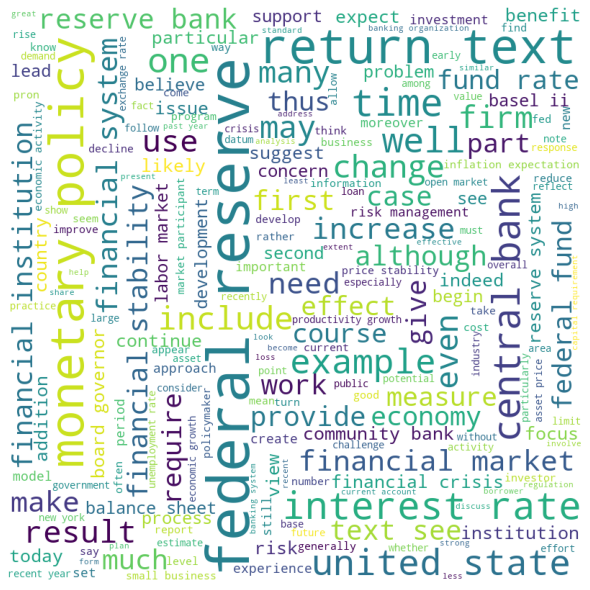

In [ ]:
plt.figure(figsize = (8, 8), facecolor = None)
plt.imshow(wordcloud)
plt.axis("off")
plt.tight_layout(pad = 0)

plt.show()

In [ ]:
nltk.download('wordnet')
from nltk.corpus import wordnet, stopwords
from nltk import FreqDist


[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [ ]:
def get_wordnet_pos(word):
    """
    Maps POS tag to word token
    """
    tag = nltk.pos_tag([word])[0][1][0].upper()
    tag_dict = {"J": wordnet.ADJ,
                "N": wordnet.NOUN,
                "V": wordnet.VERB,
                "R": wordnet.ADV}

    return tag_dict.get(tag, wordnet.NOUN)


In [ ]:

def remove_stop_words(tokens_list):

    stopwords_without_punct = []
    for word in stopwords.words('english'):
        word = word.replace("'", "")
        stopwords_without_punct.append(word)
    stopped_tokens = [w for w in tokens_list if w not in stopwords_without_punct]
    return [w for w in stopped_tokens if len(w) > 2]

Esto mismo podemos hacerlo para cada uno de los chairman y evaluar sus comentarios. Dado que la base incluye tanto los Chair como Vice Chair y Governors vamos a centrarnos en evaluar solo a los 4 más altos funcionarios del período.

In [ ]:
df["speaker"].unique()

array(['Governor Laurence H. Meyer', 'Chairman Alan Greenspan',
       'Governor Edward M. Gramlich', 'Vice Chairman Roger W. Ferguson',
       'Governor Mark W. Olson', 'Governor Susan S. Bies',
       'Governor Donald L. Kohn', 'Governor Ben S. Bernanke',
       'Chairman Ben S. Bernanke', 'Vice Chairman Donald L. Kohn',
       'Governor Kevin Warsh', 'Governor Randall S. Kroszner',
       'Governor Frederic S. Mishkin', '', 'Governor Elizabeth A. Duke',
       'Governor Daniel K. Tarullo', 'Vice Chair Janet L. Yellen',
       'Governor Sarah Bloom Raskin', 'Governor Jeremy C. Stein',
       'Governor Jerome H. Powell', 'Governor Lael Brainard',
       'Chair Janet L. Yellen', 'Vice Chairman Stanley Fischer',
       'Vice Chair for Supervision Randal K. Quarles',
       'Chairman Jerome H. Powell', 'Vice Chairman Richard H. Clarida',
       'Governor Michelle W. Bowman'], dtype=object)

In [ ]:
nombre = df["speaker"].unique()
nombre2 =[]
for elem in nombre:
  if re.findall(r'Chair', str(elem)) != [] and re.findall(r'Vice', str(elem)) == []:
    nombre2.append(elem)
#nombre3 = ', '.join([str(elem) for elem in nombre2])
nombre2

['Chairman Alan Greenspan',
 'Chairman Ben S. Bernanke',
 'Chair Janet L. Yellen',
 'Chairman Jerome H. Powell']

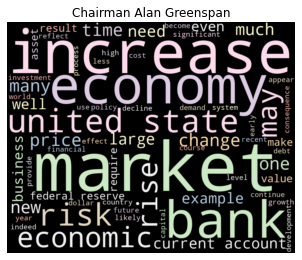

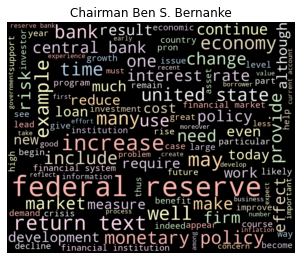

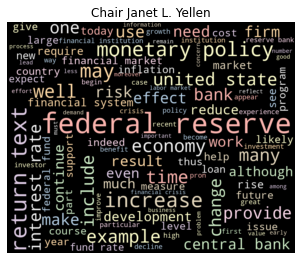

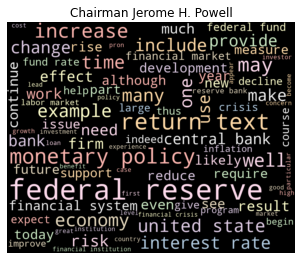

In [ ]:
comment_words = ''
stopwords = set(STOPWORDS)
#stopwords = set(stopwords.words('english'))

for chair in nombre2:
  subset = df[df["speaker"] == chair]
  for val in subset['text']:
      val = str(val)
      tokens = val.split()
      for i in range(len(tokens)):
          tokens[i] = tokens[i].lower()

      comment_words += " ".join(tokens)+" "

  wordcloud = WordCloud(width = 1000, height = 800,
                background_color ='black',
                colormap = "Pastel1",
                stopwords = stopwords,
                min_font_size = 20).generate(comment_words)

  plt.figure(figsize = (4, 4), facecolor = None)
  plt.imshow(wordcloud, interpolation="bilinear")
  plt.title(chair)
  plt.axis("off")
  plt.tight_layout(pad = 0)
  plt.show()

Miremos mas en detalle como cada uno porque parece que en Greenspan hay mas peso en menos cantidad de palabras.

In [ ]:
! pip install lexicalrichness

In [ ]:
df['link'].iloc[0]

'https://www.federalreserve.gov/boarddocs/speeches/2001/20011218/default.htm'

In [ ]:
from lexicalrichness import LexicalRichness

def lexicalrich(text):
  lex = LexicalRichness(text)
  print('Word count:',lex.words)
  print('Unique term count:', lex.terms)
  print(round(lex.terms/lex.words,2))

In [ ]:
for chair in nombre2:
  subset = df[df["speaker"] == chair]
  class color:
   PURPLE = '\033[95m'
   CYAN = '\033[96m'
   DARKCYAN = '\033[36m'
   BLUE = '\033[94m'
   GREEN = '\033[92m'
   YELLOW = '\033[93m'
   RED = '\033[91m'
   BOLD = '\033[1m'
   UNDERLINE = '\033[4m'
   END = '\033[0m'
  print(color.BOLD + chair + color.END)
  total = ' '.join(subset["text"])
  lexicalrich(total)

Chairman Alan Greenspan
Word count: 133814
Unique term count: 8459
0.06
Chairman Ben S. Bernanke
Word count: 314233
Unique term count: 14265
0.05
Chair Janet L. Yellen
Word count: 89487
Unique term count: 6992
0.08
Chairman Jerome H. Powell
Word count: 36981
Unique term count: 4590
0.12


Vemos que hay una diferencia en la cantidad de palabras distintas usadas por cada speaker. Ahora, hay alguna diferencia en el largo de sus discursos? Notablemente, Greenspan es el que discursos mas cortos tiene.

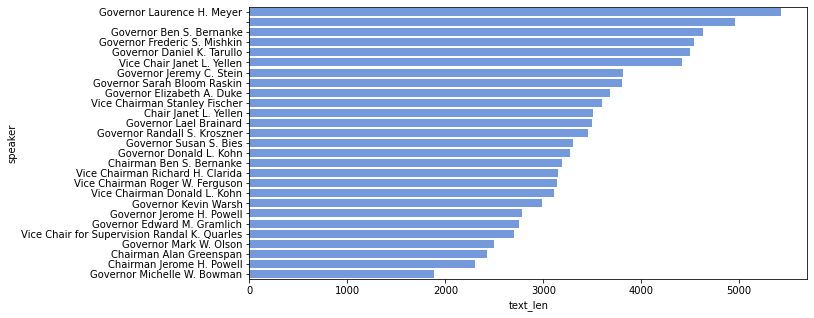

In [ ]:
plt.figure(figsize=(10,5))
grouped = df.groupby(["speaker"])["text_len"].mean()
grouped = grouped.sort_values(ascending=False)
grouped = grouped.to_frame()
grouped = grouped.reset_index()
ax = sns.barplot(x='text_len', y="speaker", data=grouped, color='cornflowerblue')

In [ ]:
df['text_len'].describe()

count     1185.000000
mean      3311.895359
std       1574.119400
min         63.000000
25%       2273.000000
50%       3276.000000
75%       4151.000000
max      10781.000000
Name: text_len, dtype: float64

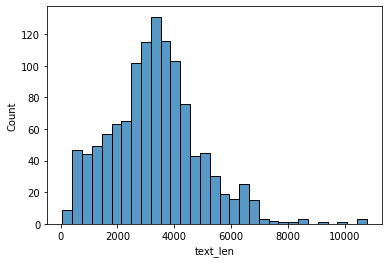

In [ ]:
sns.histplot(data=df, x="text_len")

## Sentiment Analysis

Acá un ejemplo de https://polyglot.readthedocs.io/en/latest/Sentiment.html

https://www.geeksforgeeks.org/natural-language-processing-using-polyglot-introduction/

Acá el resultado de polarity se lee así:


* '> 0 Positivo
* < 0 Negativo


In [ ]:
!pip install polyglot
!pip install pyicu
!pip install Morfessor
!pip install pycld2
!polyglot download sentiment2.en
from polyglot.text import Text

[polyglot_data] Downloading package sentiment2.en to
[polyglot_data]     /root/polyglot_data...
[polyglot_data]   Package sentiment2.en is already up-to-date!


In [ ]:
!polyglot download embeddings2.en
!polyglot download ner2.en

[polyglot_data] Downloading package embeddings2.en to
[polyglot_data]     /root/polyglot_data...
[polyglot_data]   Package embeddings2.en is already up-to-date!
[polyglot_data] Downloading package ner2.en to /root/polyglot_data...
[polyglot_data]   Package ner2.en is already up-to-date!


In [ ]:
df

,link,title,speaker,event,year,date,text_len,location,text
0,https://www.federalreserve.gov/boarddocs/speec...,Financial stability in emerging markets: What ...,Governor Laurence H. Meyer,At the Center for Strategic and International ...,2001.0,20011218,4837,D.C.,financial stability emerge market accomplish r...
1,https://www.federalreserve.gov/boarddocs/speec...,The future of money and of monetary policy,Governor Laurence H. Meyer,"At the Distinguished Lecture Program, Swarthmo...",2001.0,20011205,8574,Pennsylvania,future money monetary policy money payment sys...
2,https://www.federalreserve.gov/boarddocs/speec...,Globalization,Chairman Alan Greenspan,"At George Washington University, the Robert P....",2001.0,20011203,3055,D.C.,pleasure evening president trachtenberg former...
3,https://www.federalreserve.gov/boarddocs/speec...,The euro as an international currency,Chairman Alan Greenspan,"Before the Euro 50 Group Roundtable, Washingto...",2001.0,20011130,2358,D.C.,today would like address basic consideration c...
4,https://www.federalreserve.gov/boarddocs/speec...,Asset prices and monetary policy,Governor Edward M. Gramlich,At the New Technologies and Monetary Policy In...,2001.0,20011130,3283,France,asset price monetary policy past several year ...
...,...,...,...,...,...,...,...,...,...
1184,https://www.federalreserve.gov/newsevents/spee...,Welcoming Remarks,Chairman Jerome H. Powell,At Conversation with the Chairman: A Teacher T...,2019.0,20190206,902,D.C.,thank educators us washington join -PRON- onli...
1185,https://www.federalreserve.gov/newsevents/spee...,Inviting Participation: The Public's Role in S...,Vice Chair for Supervision Randal K. Quarles,"To the Council for Economic Education, New Yor...",2019.0,20190206,1694,New York,thank nan kind introduction thank president me...
1186,https://www.federalreserve.gov/newsevents/spee...,Strengthening the Community Reinvestment Act: ...,Governor Lael Brainard,"At ""Research Symposium on the Community Reinve...",2019.0,20190201,1462,Pennsylvania,thank participate research symposium community...
1187,https://www.federalreserve.gov/newsevents/spee...,Monetary Policy Outlook for 2019,Vice Chairman Richard H. Clarida,At the Money Marketeers of New York University...,2019.0,20190110,3004,New York,happy new year glad speak new york city live w...


In [ ]:
def polarity(text):
  text1 = Text(str(text.encode('utf-8')))
  return text1.polarity

#Ejemplo
polarity(df["text"].iloc[100])

0.18128654970760233

In [ ]:
polarity(df['text'].iloc[0])

-0.043478260869565216

**Nota, no se me rompió ninguno, todos los tex len son mayores a 10 así que solo lo puse el código. **

In [ ]:
#Para llevar a cabo la funcion primero saco cualquier caracter que rompa en polarity.

import regex

RE_BAD_CHARS = regex.compile(r"\p{Cc}|\p{Cs}")

def remove_bad_chars(text):
    return RE_BAD_CHARS.sub("", text)

remove_bad_chars("A\x96 bad char")  # Cc category

'A bad char'

In [ ]:
#df["text"] = df["text"].apply(lambda x: remove_bad_chars(x))


In [ ]:
#Algo no funciona en polarity cuando tenes lengths de texto corto. No puede sacar ningún score y sale float division by zero.
#Voy a quedarme con los que sean mayor a 10
#df = df[df["text_len"] > 10]

In [ ]:
df['polarity'] = df['text'].apply(lambda x: polarity(x))

In [ ]:
df.head()

,link,title,speaker,event,year,date,text_len,location,text,polarity
0,https://www.federalreserve.gov/boarddocs/speec...,Financial stability in emerging markets: What ...,Governor Laurence H. Meyer,At the Center for Strategic and International ...,2001.0,20011218,4837,D.C.,financial stability emerge market accomplish r...,-0.043478
1,https://www.federalreserve.gov/boarddocs/speec...,The future of money and of monetary policy,Governor Laurence H. Meyer,"At the Distinguished Lecture Program, Swarthmo...",2001.0,20011205,8574,Pennsylvania,future money monetary policy money payment sys...,0.243011
2,https://www.federalreserve.gov/boarddocs/speec...,Globalization,Chairman Alan Greenspan,"At George Washington University, the Robert P....",2001.0,20011203,3055,D.C.,pleasure evening president trachtenberg former...,0.090909
3,https://www.federalreserve.gov/boarddocs/speec...,The euro as an international currency,Chairman Alan Greenspan,"Before the Euro 50 Group Roundtable, Washingto...",2001.0,20011130,2358,D.C.,today would like address basic consideration c...,0.295082
4,https://www.federalreserve.gov/boarddocs/speec...,Asset prices and monetary policy,Governor Edward M. Gramlich,At the New Technologies and Monetary Policy In...,2001.0,20011130,3283,France,asset price monetary policy past several year ...,0.197368


In [ ]:
df["polarity"].describe()

count    1185.000000
mean        0.183164
std         0.240841
min        -1.000000
25%         0.021944
50%         0.153846
75%         0.327273
max         1.000000
Name: polarity, dtype: float64

In [ ]:
len(df['polarity'][df['polarity']<0])/ len(df['polarity'])

0.20843881856540084

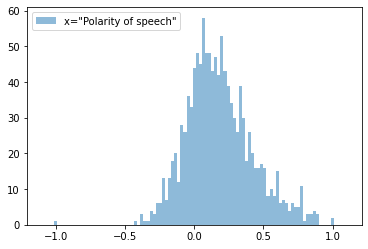

In [ ]:
#Vemos que en general los discursos tienen un score por encima de 0, es decir que pocos de ellos son clasificados como negativos.

bins = np.linspace(-1.1, 1.1, 100)

plt.hist(df['polarity'], bins, alpha=0.5, label='x="Polarity of speech"')
plt.legend(loc='upper left')
plt.show()

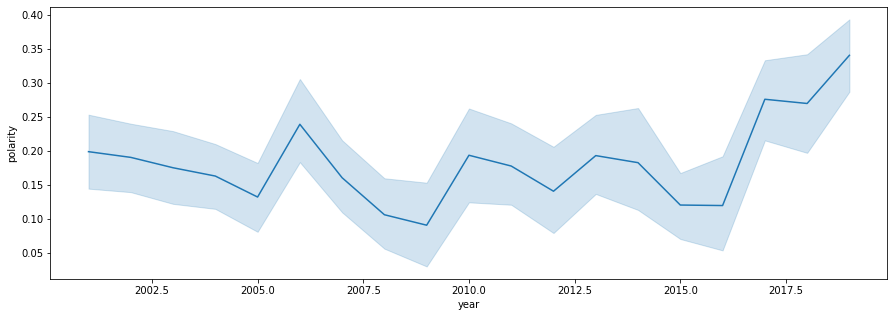

In [ ]:

plt.figure(figsize=(15,5))
sns.lineplot(data=df, x="year", y="polarity")

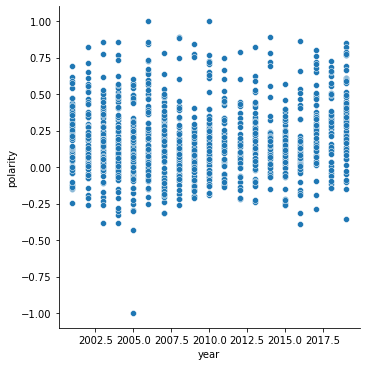

In [ ]:
sns.relplot(data=df, x="year", y="polarity")

In [ ]:
grouped = df.groupby(['year',"speaker"])["polarity"].mean()
pd.set_option('display.max_rows', 1000)
grouped

year    speaker                                     
2001.0  Chairman Alan Greenspan                         0.196161
        Governor Edward M. Gramlich                     0.228644
        Governor Laurence H. Meyer                      0.105557
        Vice Chairman Roger W. Ferguson                 0.274629
2002.0  Chairman Alan Greenspan                         0.199239
        Governor Ben S. Bernanke                        0.067824
        Governor Donald L. Kohn                         0.191011
        Governor Edward M. Gramlich                     0.211637
        Governor Laurence H. Meyer                      0.344538
        Governor Mark W. Olson                          0.266067
        Governor Susan S. Bies                          0.061800
        Vice Chairman Roger W. Ferguson                 0.201284
2003.0  Chairman Alan Greenspan                         0.198980
        Governor Ben S. Bernanke                        0.167011
        Governor Donald L. Kohn      

## Volatilidad

In [ ]:
base = pd.read_excel('baseBloomberg.xlsx')

In [ ]:
base.head()

,Dates,VIX Index,GT10 Govt,GT2 Govt,GT30 Govt,GT5 Govt
0,2001-01-01,26.85,5.114,5.104,5.458,4.979
1,2001-01-02,29.99,4.916,4.862,5.342,4.754
2,2001-01-03,26.60,5.158,4.929,5.500,4.960
3,2001-01-04,26.97,5.039,4.787,5.441,4.835
4,2001-01-05,28.67,4.931,4.569,5.398,4.656


In [ ]:
grouped = df.groupby(['year',"speaker"])["polarity"].mean()
pd.set_option('display.max_rows', 1000)
grouped

year    speaker                                     
2001.0  Chairman Alan Greenspan                         0.196161
        Governor Edward M. Gramlich                     0.228644
        Governor Laurence H. Meyer                      0.105557
        Vice Chairman Roger W. Ferguson                 0.274629
2002.0  Chairman Alan Greenspan                         0.199239
        Governor Ben S. Bernanke                        0.067824
        Governor Donald L. Kohn                         0.191011
        Governor Edward M. Gramlich                     0.211637
        Governor Laurence H. Meyer                      0.344538
        Governor Mark W. Olson                          0.266067
        Governor Susan S. Bies                          0.061800
        Vice Chairman Roger W. Ferguson                 0.201284
2003.0  Chairman Alan Greenspan                         0.198980
        Governor Ben S. Bernanke                        0.167011
        Governor Donald L. Kohn      

Se observa que los mismo índices de volatilidad.


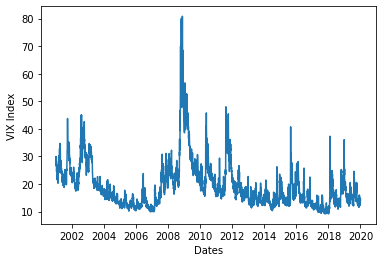

In [ ]:
sns.lineplot(data=base, x="Dates", y="VIX Index")


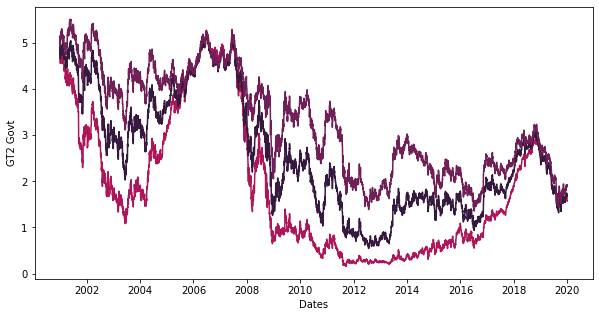

In [ ]:
fig = plt.figure(figsize=(10,5))
colors = sns.color_palette("rocket")
sns.lineplot(data=base, x="Dates", y="GT2 Govt", color = colors[2])
sns.lineplot(data=base, x="Dates", y="GT5 Govt", color = colors[0])
sns.lineplot(data=base, x="Dates", y="GT10 Govt", color = colors[1])

Analizo las palabras más comunes de los discursos en periodos de extrema volatilidad y stress financiero (como 2008) mientras

In [ ]:
def colapsar(year):
  return ' '.join(df['text'][df['year']== year ])

In [ ]:
def common_words(data, num):
  return FreqDist(nltk.tokenize.word_tokenize(data)).most_common(num)

In [ ]:
speechesde2009  = common_words(colapsar(2009), 20)

In [ ]:
speechesde2009

[('financial', 1774),
 ('market', 1274),
 ('bank', 1188),
 ('federal', 1086),
 ('reserve', 1022),
 ('credit', 941),
 ('policy', 706),
 ('institution', 654),
 ('economic', 621),
 ('rate', 617),
 ('firm', 577),
 ('risk', 572),
 ('capital', 538),
 ('crisis', 537),
 ('would', 489),
 ('system', 486),
 ('loan', 483),
 ('asset', 464),
 ('economy', 449),
 ('also', 449)]

In [ ]:
def plot_most_common_words(data, year):
  fig = plt.figure(figsize=(15, 6))

  fig.suptitle("Most common words in Speechs of "+str(year))


      # left subplot without stop words
  sns.barplot(x=[x[0] for x in data],y=[x[1] for x in data],  color='lightseagreen')
  fig.autofmt_xdate(rotation=45)


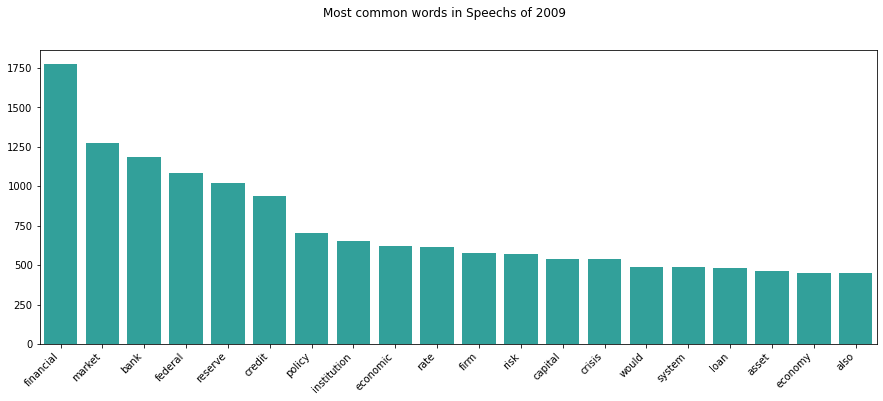

In [ ]:
plot_most_common_words(speechesde2009, 2009)

Comparamos una vez más palabras comunes, pero esta vez en otro formato, y en este caso dos escenarios extremos un escenario de alta volatilidad como fue la crisis subprime (iniciada en Agosto/Septiembre de 2008 pero que se desarrollo mayormente en 2009, con un escenario de suma estabilidad y crecimiento (que tal vez fue excesivo e insostenible).

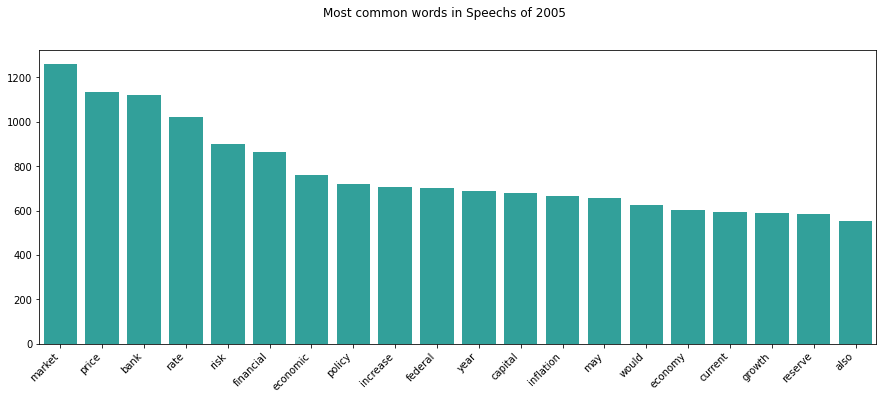

In [ ]:
speechesde2005 = common_words(colapsar(2005), 20)
plot_most_common_words(speechesde2005, 2005)

Si bien hay palabras que son denominador comun en ambas: 'market', 'bank', 'risk', 'financial', 'federal', 'policy', 'rate' se observa que palabras propias de la crisis  aparecen en el speeche de 2009: 'crisis', 'system' (ya que fue una crisis sistémica), 'loan', mientras que en 2006 aparece la palabra 'increase' y 'growth'

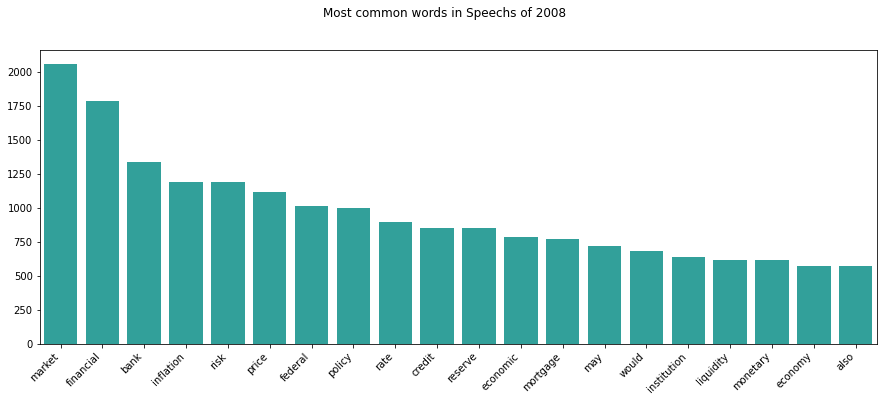

In [ ]:
speechesde2008 = common_words(colapsar(2008), 20)
plot_most_common_words(speechesde2008, 2008)

Mientras que en los speeches de 2008, el año en que se desencadeno la crisis estuvieron presentes palabras relacionadas especificamente con la subprime: 'mortgage', 'liquidity' (por las inyecciones masiva de liquidez, 'credit'.

Elimino palabras en comun market, financial, bank, federal, policy,rate

In [ ]:
lista = ['financial', 'market', 'bank', 'risk', 'federal', 'economic', 'economy', 'reserve', 'also', 'rate', 'policy']
speeches2009b = []
speeches2008b = []
speeches2005b =[]
for i in range(20):
  if speechesde2009[i][0] not in lista:
    speeches2009b.append(speechesde2009[i])
  if speechesde2008[i][0] not in lista:
    speeches2008b.append(speechesde2008[i])
  if speechesde2005[i][0] not in lista:
    speeches2005b.append(speechesde2005[i])




Text(0.5, 1.0, 'Most common words in Speechs of 2009')

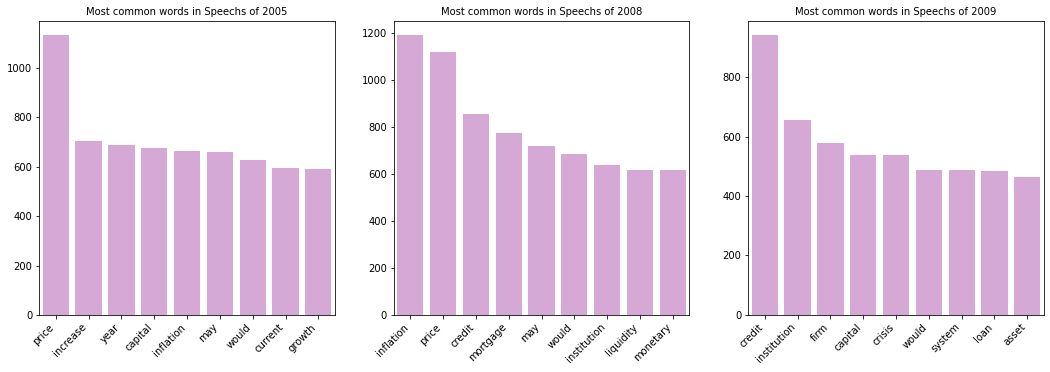

In [ ]:

fig, axes = plt.subplots(1, 3, figsize=(18, 6))





    # left subplot without stop words

sns.barplot(x=[x[0] for x in speeches2005b],y=[x[1] for x in speeches2005b],  color='plum', ax=axes[0])
axes[0].set_title("Most common words in Speechs of 2005", fontsize=10)
fig.autofmt_xdate(rotation=45)
sns.barplot(x=[x[0] for x in speeches2008b],y=[x[1] for x in speeches2008b],  color='plum', ax=axes[1])
fig.autofmt_xdate(rotation=45)
axes[1].set_title("Most common words in Speechs of 2008", fontsize=10)
sns.barplot(x=[x[0] for x in speeches2009b],y=[x[1] for x in speeches2009b],  color='plum', ax=axes[2])
fig.autofmt_xdate(rotation=45)
axes[2].set_title("Most common words in Speechs of 2009", fontsize=10)


In [ ]:
base_bonos = base

In [ ]:
base_bonos['change_gt2_t1'] = base['GT2 Govt'].diff(-1)*(-1)
base_bonos['change_gt2_t3'] = base['GT2 Govt'].diff(-3)*(-1)
base_bonos['change_gt2_t5'] = base['GT2 Govt'].diff(-5)*(-1)
base_bonos['change_gt2_t10'] = base['GT2 Govt'].diff(-10)*(-1)
base_bonos['change_gt2_t20'] = base['GT2 Govt'].diff(-20)*(-1)
base_bonos['change_gt2_t50'] = base['GT2 Govt'].diff(-50)*(-1)
base_bonos['change_gt2_t100'] = base['GT2 Govt'].diff(-100)*(-1)

base_bonos.head()

,Dates,VIX Index,GT10 Govt,GT2 Govt,GT30 Govt,GT5 Govt,change_gt2_t1,change_gt2_t3,change_gt2_t5,change_gt2_t10,change_gt2_t20,change_gt2_t50,change_gt2_t100
0,2001-01-01,26.85,5.114,5.104,5.458,4.979,-0.242,-0.317,-0.544,-0.213,-0.342,-0.702,-0.762
1,2001-01-02,29.99,4.916,4.862,5.342,4.754,0.067,-0.293,-0.203,0.019,-0.166,-0.427,-0.536
2,2001-01-03,26.60,5.158,4.929,5.500,4.960,-0.142,-0.369,-0.154,-0.107,-0.357,-0.654,-0.680
3,2001-01-04,26.97,5.039,4.787,5.441,4.835,-0.218,-0.128,-0.054,-0.067,-0.232,-0.571,-0.486
4,2001-01-05,28.67,4.931,4.569,5.398,4.656,-0.009,0.206,0.322,0.166,0.068,-0.329,-0.301


Agrego una columna para analizar si la variación de la volatilidad es positiva o negativa.

In [ ]:
# Agrego la columna que me dice si la volatilidad aumento o bajo respecto al periodo anterior. No mr importa aca cuanto sube o baja porque despues lo paso a categorica

base['change_t1'] = base['VIX Index'].diff(-1)*(-1)
base['change_t2'] = base['VIX Index'].diff(-2)*(-1)
base['change_t3'] = base['VIX Index'].diff(-3)*(-1)
base['change_t5'] = base['VIX Index'].diff(-5)*(-1)
base['change_t10'] = base['VIX Index'].diff(-10)*(-1)
base['change_t20'] = base['VIX Index'].diff(-20)*(-1)
base['change_t50'] = base['VIX Index'].diff(-50)*(-1)
base['change_t100'] = base['VIX Index'].diff(-100)*(-1)

base.head()

,Dates,VIX Index,GT10 Govt,GT2 Govt,GT30 Govt,GT5 Govt,change_gt2_t1,change_gt2_t3,change_gt2_t5,change_gt2_t10,change_gt2_t20,change_gt2_t50,change_gt2_t100,change_t1,change_t2,change_t3,change_t5,change_t10,change_t20,change_t50,change_t100
0,2001-01-01,26.85,5.114,5.104,5.458,4.979,-0.242,-0.317,-0.544,-0.213,-0.342,-0.702,-0.762,3.14,-0.25,0.12,2.99,-2.29,-4.24,3.47,-6.09
1,2001-01-02,29.99,4.916,4.862,5.342,4.754,0.067,-0.293,-0.203,0.019,-0.166,-0.427,-0.536,-3.39,-3.02,-1.32,-2.00,-4.71,-7.42,-2.44,-8.64
2,2001-01-03,26.60,5.158,4.929,5.500,4.960,-0.142,-0.369,-0.154,-0.107,-0.357,-0.654,-0.680,0.37,2.07,3.24,0.20,-1.67,-4.58,3.01,-4.52
3,2001-01-04,26.97,5.039,4.787,5.441,4.835,-0.218,-0.128,-0.054,-0.067,-0.232,-0.571,-0.486,1.70,2.87,1.02,-1.18,-3.60,-5.31,1.59,-6.40
4,2001-01-05,28.67,4.931,4.569,5.398,4.656,-0.009,0.206,0.322,0.166,0.068,-0.329,-0.301,1.17,-0.68,-1.87,-4.11,-5.43,-6.72,1.24,-8.07


In [ ]:
base = base.rename(columns = {'VIX Index': 'VIX_Index'})

In [ ]:
#Agrego el comportamiento del vix anterior.
base = base.sort_values("Dates",ascending=True)
base['previous_vix'] = base.VIX_Index.rolling(15).mean()
base.head(20)

,Dates,VIX_Index,GT10 Govt,GT2 Govt,GT30 Govt,GT5 Govt,change_gt2_t1,change_gt2_t3,change_gt2_t5,change_gt2_t10,change_gt2_t20,change_gt2_t50,change_gt2_t100,change_t1,change_t2,change_t3,change_t5,change_t10,change_t20,change_t50,change_t100,previous_vix
0,2001-01-01,26.85,5.114,5.104,5.458,4.979,-0.242,-0.317,-0.544,-0.213,-0.342,-0.702,-0.762,3.14,-0.25,0.12,2.99,-2.29,-4.24,3.47,-6.09,NaN
1,2001-01-02,29.99,4.916,4.862,5.342,4.754,0.067,-0.293,-0.203,0.019,-0.166,-0.427,-0.536,-3.39,-3.02,-1.32,-2.00,-4.71,-7.42,-2.44,-8.64,NaN
2,2001-01-03,26.60,5.158,4.929,5.500,4.960,-0.142,-0.369,-0.154,-0.107,-0.357,-0.654,-0.680,0.37,2.07,3.24,0.20,-1.67,-4.58,3.01,-4.52,NaN
3,2001-01-04,26.97,5.039,4.787,5.441,4.835,-0.218,-0.128,-0.054,-0.067,-0.232,-0.571,-0.486,1.70,2.87,1.02,-1.18,-3.60,-5.31,1.59,-6.40,NaN
4,2001-01-05,28.67,4.931,4.569,5.398,4.656,-0.009,0.206,0.322,0.166,0.068,-0.329,-0.301,1.17,-0.68,-1.87,-4.11,-5.43,-6.72,1.24,-8.07,NaN
5,2001-01-08,29.84,4.956,4.560,5.447,4.666,0.099,0.173,0.331,0.183,0.110,-0.262,-0.292,-1.85,-3.04,-4.05,-5.28,-6.59,-7.65,-0.06,-9.24,NaN
6,2001-01-09,27.99,5.000,4.659,5.429,4.733,0.116,0.232,0.222,0.169,0.028,-0.454,-0.347,-1.19,-2.20,-3.43,-2.71,-6.42,-6.01,2.97,-5.85,NaN
7,2001-01-10,26.80,5.104,4.775,5.499,4.832,-0.042,0.116,0.047,0.069,-0.055,-0.562,-0.472,-1.01,-2.24,-2.24,-1.87,-4.77,-5.13,5.13,-4.04,NaN
8,2001-01-11,25.79,5.110,4.733,5.540,4.799,0.158,0.148,-0.013,0.029,-0.021,-0.588,-0.545,-1.23,-1.23,-0.51,-2.42,-3.15,-4.33,7.05,-3.15,NaN
9,2001-01-12,24.56,5.250,4.891,5.618,4.952,-0.000,-0.069,-0.156,-0.120,-0.255,-0.630,-0.678,-0.00,0.72,0.37,-1.32,-1.99,-2.53,5.89,-2.97,NaN


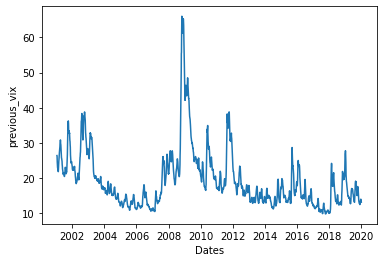

In [ ]:
sns.lineplot(data=base, x="Dates", y="previous_vix")

In [ ]:
df = df.reset_index(drop = True)


In [ ]:
from datetime import datetime

In [ ]:
df['date'] =  pd.to_datetime(df['date'])
df["date"].describe()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: FutureWarning: Treating datetime data as categorical rather than numeric in `.describe` is deprecated and will be removed in a future version of pandas. Specify `datetime_is_numeric=True` to silence this warning and adopt the future behavior now.
  


count                    1184
unique                    998
top       2002-11-12 00:00:00
freq                        5
first     2001-01-12 00:00:00
last      2019-12-18 00:00:00
Name: date, dtype: object

In [ ]:
df["date"].loc[0].weekday()

def day_of_week(date):
  return date.weekday()

Dado que no tenemos cotización los fines de semanas pero si tenemos , se debe tratar de alguna manera.

In [ ]:

df['weekday'] = df['date'].apply(day_of_week)
base['weekday'] = base['Dates'].apply(day_of_week)

In [ ]:
#Aca hay un tema, vemos que los discursos pasan tambien los fines de semana.
uniq_days = df['weekday'].unique()
np.sort(uniq_days)

array([ 0.,  1.,  2.,  3.,  4.,  5.,  6., nan])

Analizando la distribución de discursos por día, se observa que hay menos discursos los fines de semana, mientras que la mayor cantidad de discursos ocurren los días jueves.

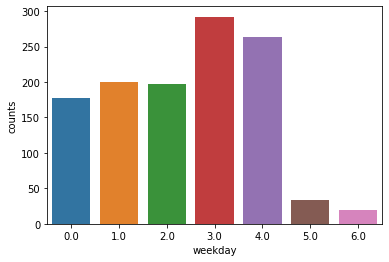

In [ ]:
grouped = df.groupby(["weekday"]).size()
grouped = grouped.sort_values(ascending=False)
grouped = grouped.to_frame()
grouped = grouped.rename(columns= {0: 'counts'})
grouped = grouped.reset_index()
ax = sns.barplot(x='weekday', y="counts", data=grouped)

Chequeo que en la base solo tenemos días hábiles

In [ ]:

np.sort(base['weekday'].unique())

array([0, 1, 2, 3, 4])

In [ ]:
#Ahora, para ver la volatilidad deberia quedarme con que el t0 es el último día hábil antes del discurso.
import  datetime
df["date_mod"] = df['date']

contador = 0
for day in df['date_mod']:
  if day.weekday() == 5:
    df['date_mod'].loc[contador] = day + datetime.timedelta(days= day.weekday()-6)
  if day.weekday() == 6:
    df['date_mod'].loc[contador] = day + datetime.timedelta(days= day.weekday()-8)
  contador = contador +1

/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)


In [ ]:
df_vix = df.merge(base, how = 'left', left_on = 'date_mod', right_on = 'Dates')
df_vix = df_vix.drop(labels = ['Dates'], axis=1)
df_vix

,link,title,speaker,event,year,date,text_len,location,text,polarity,weekday_x,date_mod,VIX_Index,GT10 Govt,GT2 Govt,GT30 Govt,GT5 Govt,change_gt2_t1,change_gt2_t3,change_gt2_t5,change_gt2_t10,change_gt2_t20,change_gt2_t50,change_gt2_t100,change_t1,change_t2,change_t3,change_t5,change_t10,change_t20,change_t50,change_t100,previous_vix,weekday_y
0,https://www.federalreserve.gov/boarddocs/speec...,Financial stability in emerging markets: What ...,Governor Laurence H. Meyer,At the Center for Strategic and International ...,2001.0,2001-12-18,4837,D.C.,financial stability emerge market accomplish r...,-0.043478,1.0,2001-12-18,23.29,5.121,3.087,5.512,4.421,-0.017,0.042,0.060,-0.037,-0.321,-0.058,0.029,-0.71,0.38,-0.79,-0.67,0.51,-0.59,-1.61,-1.35,24.591333,1.0
1,https://www.federalreserve.gov/boarddocs/speec...,The future of money and of monetary policy,Governor Laurence H. Meyer,"At the Distinguished Lecture Program, Swarthmo...",2001.0,2001-12-05,8574,Pennsylvania,future money monetary policy money payment sys...,0.243011,2.0,2001-12-05,23.02,4.893,3.061,5.355,4.230,0.107,-0.008,-0.090,0.009,0.144,-0.024,0.172,0.69,0.47,2.60,1.85,-0.44,-0.31,-2.17,-2.25,24.428000,2.0
2,https://www.federalreserve.gov/boarddocs/speec...,Globalization,Chairman Alan Greenspan,"At George Washington University, the Robert P....",2001.0,2001-12-03,3055,D.C.,pleasure evening president trachtenberg former...,0.090909,0.0,2001-12-03,25.77,4.687,2.776,5.243,3.986,0.024,0.392,0.277,0.361,0.250,0.162,0.533,-1.69,-2.75,-2.06,-0.15,-1.51,-1.97,-3.99,-6.00,24.823333,0.0
3,https://www.federalreserve.gov/boarddocs/speec...,The euro as an international currency,Chairman Alan Greenspan,"Before the Euro 50 Group Roundtable, Washingto...",2001.0,2001-11-30,2358,D.C.,today would like address basic consideration c...,0.295082,4.0,2001-11-30,23.84,4.752,2.841,5.286,4.064,-0.065,0.220,0.360,0.312,0.316,0.064,0.477,1.93,0.24,-0.82,-0.35,0.79,-2.44,-0.58,-5.54,25.062000,4.0
4,https://www.federalreserve.gov/boarddocs/speec...,Asset prices and monetary policy,Governor Edward M. Gramlich,At the New Technologies and Monetary Policy In...,2001.0,2001-11-30,3283,France,asset price monetary policy past several year ...,0.197368,4.0,2001-11-30,23.84,4.752,2.841,5.286,4.064,-0.065,0.220,0.360,0.312,0.316,0.064,0.477,1.93,0.24,-0.82,-0.35,0.79,-2.44,-0.58,-5.54,25.062000,4.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1180,https://www.federalreserve.gov/newsevents/spee...,Welcoming Remarks,Chairman Jerome H. Powell,At Conversation with the Chairman: A Teacher T...,2019.0,2019-02-06,902,D.C.,thank educators us washington join -PRON- onli...,0.784615,2.0,2019-02-06,15.38,2.696,2.526,3.034,2.504,-0.044,-0.039,0.007,-0.027,-0.009,-0.125,-0.755,0.99,0.34,0.59,0.27,-1.36,0.36,-2.78,0.83,17.689333,2.0
1181,https://www.federalreserve.gov/newsevents/spee...,Inviting Participation: The Public's Role in S...,Vice Chair for Supervision Randal K. Quarles,"To the Council for Economic Education, New Yor...",2019.0,2019-02-06,1694,New York,thank nan kind introduction thank president me...,0.403846,2.0,2019-02-06,15.38,2.696,2.526,3.034,2.504,-0.044,-0.039,0.007,-0.027,-0.009,-0.125,-0.755,0.99,0.34,0.59,0.27,-1.36,0.36,-2.78,0.83,17.689333,2.0
1182,https://www.federalreserve.gov/newsevents/spee...,Strengthening the Community Reinvestment Act: ...,Governor Lael Brainard,"At ""Research Symposium on the Community Reinve...",2019.0,2019-02-01,1462,Pennsylvania,thank participate research symposium community...,0.775000,4.0,2019-02-01,16.14,2.685,2.505,3.026,2.504,0.032,0.021,-0.038,0.012,0.050,-0.112,-0.735,-0.41,-0.57,-0.76,-0.42,-1.23,-2.57,-4.13,-0.74,18.358000,4.0
1183,https://www.federalreserve.gov/newsevents/spee...,Monetary Policy Outlook for 2019,Vice Chairman Richard H. Clarida,At the Money Marketeers of New York University...,2019.0,2019-01-10,3004,New York,happy new year glad speak new york city live 

/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


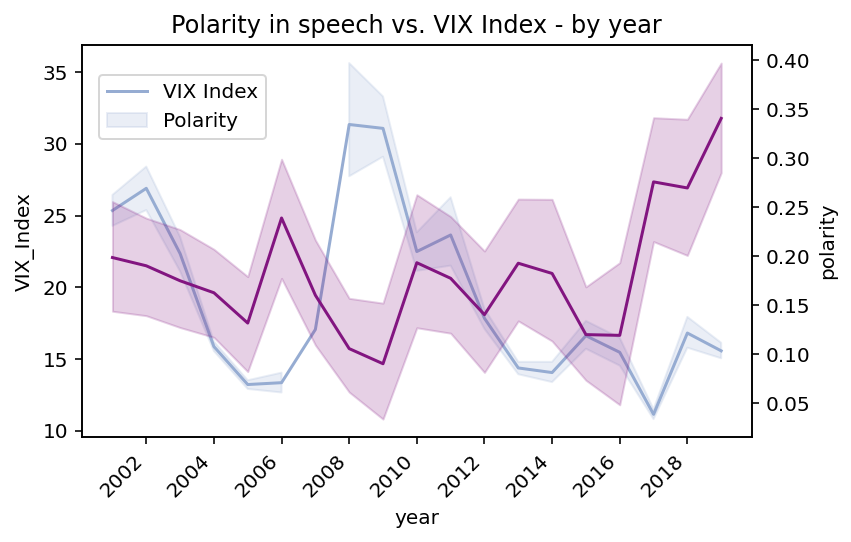

In [ ]:
import matplotlib.dates as mdates
fig = plt.figure(figsize=(6,4),dpi=144)
ax = fig.add_subplot(111)

colors = sns.color_palette("BuPu")
ax2 = ax.twinx()

ax = sns.lineplot('year', 'VIX_Index', data=df_vix, color=colors[2], ax=ax)
ax2 = sns.lineplot('year', 'polarity', data=df_vix, color=colors[5], ax=ax2)

fig.legend(['VIX Index','Polarity'],loc="upper left", bbox_to_anchor=(0.01, 0.95), bbox_transform=ax.transAxes)


locator = mdates.AutoDateLocator()
ax.xaxis.set_major_locator(locator)

fig.autofmt_xdate(rotation=45)
ax.set(title=f'Polarity in speech vs. VIX Index - by year')
plt.show()

In [ ]:
df_vix['VIX_Index'].dtype

dtype('float64')

In [ ]:
import math

df_vix_i= df_vix['VIX_Index']
df_vix_polarity_lag = df_vix['polarity'].shift(-1)



In [ ]:
from scipy import stats
stats.spearmanr(df_vix_polarity_lag, df_vix_i)[0]

nan

In [ ]:
df_vix_i.corr(df_vix_polarity_lag)


-0.09666020815178752

In [ ]:
df_vix['VIX_Index'].corr(df_vix['polarity'])

-0.08844994948132162

In [ ]:
df_vix

,link,title,speaker,event,year,date,text_len,location,text,polarity,weekday_x,date_mod,VIX_Index,GT10 Govt,GT2 Govt,GT30 Govt,GT5 Govt,change_gt2_t1,change_gt2_t3,change_gt2_t5,change_gt2_t10,change_gt2_t20,change_gt2_t50,change_gt2_t100,change_t1,change_t2,change_t3,change_t5,change_t10,change_t20,change_t50,change_t100,previous_vix,weekday_y
0,https://www.federalreserve.gov/boarddocs/speec...,Financial stability in emerging markets: What ...,Governor Laurence H. Meyer,At the Center for Strategic and International ...,2001.0,2001-12-18,4837,D.C.,financial stability emerge market accomplish r...,-0.043478,1.0,2001-12-18,23.29,5.121,3.087,5.512,4.421,-0.017,0.042,0.060,-0.037,-0.321,-0.058,0.029,-0.71,0.38,-0.79,-0.67,0.51,-0.59,-1.61,-1.35,24.591333,1.0
1,https://www.federalreserve.gov/boarddocs/speec...,The future of money and of monetary policy,Governor Laurence H. Meyer,"At the Distinguished Lecture Program, Swarthmo...",2001.0,2001-12-05,8574,Pennsylvania,future money monetary policy money payment sys...,0.243011,2.0,2001-12-05,23.02,4.893,3.061,5.355,4.230,0.107,-0.008,-0.090,0.009,0.144,-0.024,0.172,0.69,0.47,2.60,1.85,-0.44,-0.31,-2.17,-2.25,24.428000,2.0
2,https://www.federalreserve.gov/boarddocs/speec...,Globalization,Chairman Alan Greenspan,"At George Washington University, the Robert P....",2001.0,2001-12-03,3055,D.C.,pleasure evening president trachtenberg former...,0.090909,0.0,2001-12-03,25.77,4.687,2.776,5.243,3.986,0.024,0.392,0.277,0.361,0.250,0.162,0.533,-1.69,-2.75,-2.06,-0.15,-1.51,-1.97,-3.99,-6.00,24.823333,0.0
3,https://www.federalreserve.gov/boarddocs/speec...,The euro as an international currency,Chairman Alan Greenspan,"Before the Euro 50 Group Roundtable, Washingto...",2001.0,2001-11-30,2358,D.C.,today would like address basic consideration c...,0.295082,4.0,2001-11-30,23.84,4.752,2.841,5.286,4.064,-0.065,0.220,0.360,0.312,0.316,0.064,0.477,1.93,0.24,-0.82,-0.35,0.79,-2.44,-0.58,-5.54,25.062000,4.0
4,https://www.federalreserve.gov/boarddocs/speec...,Asset prices and monetary policy,Governor Edward M. Gramlich,At the New Technologies and Monetary Policy In...,2001.0,2001-11-30,3283,France,asset price monetary policy past several year ...,0.197368,4.0,2001-11-30,23.84,4.752,2.841,5.286,4.064,-0.065,0.220,0.360,0.312,0.316,0.064,0.477,1.93,0.24,-0.82,-0.35,0.79,-2.44,-0.58,-5.54,25.062000,4.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1180,https://www.federalreserve.gov/newsevents/spee...,Welcoming Remarks,Chairman Jerome H. Powell,At Conversation with the Chairman: A Teacher T...,2019.0,2019-02-06,902,D.C.,thank educators us washington join -PRON- onli...,0.784615,2.0,2019-02-06,15.38,2.696,2.526,3.034,2.504,-0.044,-0.039,0.007,-0.027,-0.009,-0.125,-0.755,0.99,0.34,0.59,0.27,-1.36,0.36,-2.78,0.83,17.689333,2.0
1181,https://www.federalreserve.gov/newsevents/spee...,Inviting Participation: The Public's Role in S...,Vice Chair for Supervision Randal K. Quarles,"To the Council for Economic Education, New Yor...",2019.0,2019-02-06,1694,New York,thank nan kind introduction thank president me...,0.403846,2.0,2019-02-06,15.38,2.696,2.526,3.034,2.504,-0.044,-0.039,0.007,-0.027,-0.009,-0.125,-0.755,0.99,0.34,0.59,0.27,-1.36,0.36,-2.78,0.83,17.689333,2.0
1182,https://www.federalreserve.gov/newsevents/spee...,Strengthening the Community Reinvestment Act: ...,Governor Lael Brainard,"At ""Research Symposium on the Community Reinve...",2019.0,2019-02-01,1462,Pennsylvania,thank participate research symposium community...,0.775000,4.0,2019-02-01,16.14,2.685,2.505,3.026,2.504,0.032,0.021,-0.038,0.012,0.050,-0.112,-0.735,-0.41,-0.57,-0.76,-0.42,-1.23,-2.57,-4.13,-0.74,18.358000,4.0
1183,https://www.federalreserve.gov/newsevents/spee...,Monetary Policy Outlook for 2019,Vice Chairman Richard H. Clarida,At the Money Marketeers of New York University...,2019.0,2019-01-10,3004,New York,happy new year glad speak new york city live 

In [ ]:
#Armo las categorias de volatilidad

df_vix['category_t1'] = np.where(df_vix['change_t1']>0, 1, 0)
df_vix['category_t2'] = np.where(df_vix['change_t2']>0, 1, 0)
df_vix['category_t3'] = np.where(df_vix['change_t3']>0, 1, 0)
df_vix['category_t5'] = np.where(df_vix['change_t5']>0, 1, 0)
df_vix['category_t10'] = np.where(df_vix['change_t10']>0, 1, 0)
df_vix['category_t20'] = np.where(df_vix['change_t20']>0, 1, 0)
df_vix['category_t50'] = np.where(df_vix['change_t50']>0, 1, 0)
df_vix['category_t100'] = np.where(df_vix['change_t100']>0, 1, 0)

In [ ]:
grouped = df_vix.groupby(["category_t1"]).size()
grouped

category_t1
0    689
1    496
dtype: int64

In [ ]:
grouped = df_vix.groupby(["category_t3"]).size()
grouped

category_t3
0    662
1    523
dtype: int64

In [ ]:
grouped = df_vix.groupby(["category_t50"]).size()
grouped

category_t50
0    705
1    480
dtype: int64

## Entrenamiento y Clasificación

### Volatilidad

#### 5 días

In [ ]:
df_vix.head(5)

,link,title,speaker,event,year,date,text_len,location,text,polarity,weekday_x,date_mod,VIX_Index,GT10 Govt,GT2 Govt,GT30 Govt,GT5 Govt,change_gt2_t1,change_gt2_t3,change_gt2_t5,change_gt2_t10,change_gt2_t20,change_gt2_t50,change_gt2_t100,change_t1,change_t2,change_t3,change_t5,change_t10,change_t20,change_t50,change_t100,previous_vix,weekday_y,category_t1,category_t2,category_t3,category_t5,category_t10,category_t20,category_t50,category_t100
0,https://www.federalreserve.gov/boarddocs/speec...,Financial stability in emerging markets: What ...,Governor Laurence H. Meyer,At the Center for Strategic and International ...,2001.0,2001-12-18,4837,D.C.,financial stability emerge market accomplish r...,-0.043478,1.0,2001-12-18,23.29,5.121,3.087,5.512,4.421,-0.017,0.042,0.060,-0.037,-0.321,-0.058,0.029,-0.71,0.38,-0.79,-0.67,0.51,-0.59,-1.61,-1.35,24.591333,1.0,0,1,0,0,1,0,0,0
1,https://www.federalreserve.gov/boarddocs/speec...,The future of money and of monetary policy,Governor Laurence H. Meyer,"At the Distinguished Lecture Program, Swarthmo...",2001.0,2001-12-05,8574,Pennsylvania,future money monetary policy money payment sys...,0.243011,2.0,2001-12-05,23.02,4.893,3.061,5.355,4.230,0.107,-0.008,-0.090,0.009,0.144,-0.024,0.172,0.69,0.47,2.60,1.85,-0.44,-0.31,-2.17,-2.25,24.428000,2.0,1,1,1,1,0,0,0,0
2,https://www.federalreserve.gov/boarddocs/speec...,Globalization,Chairman Alan Greenspan,"At George Washington University, the Robert P....",2001.0,2001-12-03,3055,D.C.,pleasure evening president trachtenberg former...,0.090909,0.0,2001-12-03,25.77,4.687,2.776,5.243,3.986,0.024,0.392,0.277,0.361,0.250,0.162,0.533,-1.69,-2.75,-2.06,-0.15,-1.51,-1.97,-3.99,-6.00,24.823333,0.0,0,0,0,0,0,0,0,0
3,https://www.federalreserve.gov/boarddocs/speec...,The euro as an international currency,Chairman Alan Greenspan,"Before the Euro 50 Group Roundtable, Washingto...",2001.0,2001-11-30,2358,D.C.,today would like address basic consideration c...,0.295082,4.0,2001-11-30,23.84,4.752,2.841,5.286,4.064,-0.065,0.220,0.360,0.312,0.316,0.064,0.477,1.93,0.24,-0.82,-0.35,0.79,-2.44,-0.58,-5.54,25.062000,4.0,1,1,0,0,1,0,0,0
4,https://www.federalreserve.gov/boarddocs/speec...,Asset prices and monetary policy,Governor Edward M. Gramlich,At the New Technologies and Monetary Policy In...,2001.0,2001-11-30,3283,France,asset price monetary policy past several year ...,0.197368,4.0,2001-11-30,23.84,4.752,2.841,5.286,4.064,-0.065,0.220,0.360,0.312,0.316,0.064,0.477,1.93,0.24,-0.82,-0.35,0.79,-2.44,-0.58,-5.54,25.062000,4.0,1,1,0,0,1,0,0,0


In [ ]:
train =pd.DataFrame()
train['text'] = df_vix['text']
train['text_len'] = df_vix['text_len']
train['polarity'] = df_vix['polarity']
train['category_t5'] = df_vix['category_t5']
train['previous_vix'] = df_vix['previous_vix']

train.head()

,text,text_len,polarity,category_t5,previous_vix
0,financial stability emerge market accomplish r...,4837,-0.043478,0,24.591333
1,future money monetary policy money payment sys...,8574,0.243011,1,24.428000
2,pleasure evening president trachtenberg former...,3055,0.090909,0,24.823333
3,today would like address basic consideration c...,2358,0.295082,0,25.062000
4,asset price monetary policy past several year ...,3283,0.197368,0,25.062000


In [ ]:
from sklearn.model_selection import train_test_split
x,y=train.iloc[:,train.columns != 'category_t5'],train.iloc[:, 3]
x_train,x_test,y_train,y_test=train_test_split(x,y,train_size=0.8,test_size=0.2,random_state=123)
x_train.head()

,text,text_len,polarity,previous_vix
50,pleasure icbas national convention large compl...,2517,0.050847,25.455333
991,-PRON- be grateful organizer invite participat...,2070,0.011765,17.264000
708,united states severe recessiona consequence co...,3720,0.203008,17.167333
486,economic picture evolve rapidly past month sep...,2491,0.157303,19.693333
476,operate year favorable condition ample liquidi...,3992,-0.188732,20.906667


In [ ]:
x_train.reset_index(drop = True, inplace = True)
y_train.reset_index(drop = True, inplace = True)
y_train=y_train.astype('int')
y_train.head()

0    1
1    0
2    0
3    1
4    1
Name: category_t5, dtype: int64

In [ ]:
vectorizer = TfidfVectorizer()
X_train = vectorizer.fit_transform(x_train['text'])
print(X_train.shape)

X_train_feat = pd.concat([x_train['text_len'], x_train['polarity'], pd.DataFrame(X_train.toarray())], axis=1)
print(X_train_feat.shape)
X_train_feat = scipy.sparse.csr_matrix(X_train_feat)

(948, 45191)
(948, 45193)


In [ ]:
tuned_parameters = [{'kernel': ['rbf'],'C': [0.1,1,5, 10, 25]}]
                   # {'kernel': ['linear'], 'C': [0.1, 1, 10, 25]}]

svm = GridSearchCV(SVC(), tuned_parameters, cv=3)
svm.fit(X_train_feat, y_train)

GridSearchCV(cv=3, error_score=nan,
             estimator=SVC(C=1.0, break_ties=False, cache_size=200,
                           class_weight=None, coef0=0.0,
                           decision_function_shape='ovr', degree=3,
                           gamma='scale', kernel='rbf', max_iter=-1,
                           probability=False, random_state=None, shrinking=True,
                           tol=0.001, verbose=False),
             iid='deprecated', n_jobs=None,
             param_grid=[{'C': [0.1, 1, 5, 10, 25], 'kernel': ['rbf']}],
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring=None, verbose=0)

In [ ]:
svm_clf_scores = cross_val_score(svm.best_estimator_, X_train_feat, y_train, cv=5)
print(svm_clf_scores)
print("Accuracy: %0.2f (+/- %0.2f)" % (svm_clf_scores.mean(), svm_clf_scores.std() * 2))

[0.56315789 0.56315789 0.56315789 0.56084656 0.56613757]
Accuracy: 0.56 (+/- 0.00)


#### 50 días

In [ ]:
train = df_vix.iloc[:,[6,8,9,30,35]]
train.head()

,text_len,text,polarity,change_t50,category_t2
0,4837,financial stability emerge market accomplish r...,-0.043478,-1.61,1
1,8574,future money monetary policy money payment sys...,0.243011,-2.17,1
2,3055,pleasure evening president trachtenberg former...,0.090909,-3.99,0
3,2358,today would like address basic consideration c...,0.295082,-0.58,1
4,3283,asset price monetary policy past several year ...,0.197368,-0.58,1


In [ ]:
x,y=train.iloc[:,0:4],train.iloc[:,4]
x_train,x_test,y_train,y_test=train_test_split(x,y,train_size=0.8,test_size=0.2,random_state=123)
x_train.head()

,text_len,text,polarity,change_t50
50,2517,pleasure icbas national convention large compl...,0.050847,-2.23
991,2070,-PRON- be grateful organizer invite participat...,0.011765,-7.75
708,3720,united states severe recessiona consequence co...,0.203008,8.57
486,2491,economic picture evolve rapidly past month sep...,0.157303,4.12
476,3992,operate year favorable condition ample liquidi...,-0.188732,-1.41


In [ ]:
x_train.reset_index(drop = True, inplace = True)
y_train.reset_index(drop = True, inplace = True)
y_train=y_train.astype('int')


In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
import scipy
from scipy.sparse import coo_matrix, hstack

vectorizer = TfidfVectorizer()
X_train = vectorizer.fit_transform(x_train['text'])
print(X_train.shape)

X_train_feat = pd.concat([x_train['text_len'], x_train['polarity'], pd.DataFrame(X_train.toarray())], axis=1)
print(X_train_feat.shape)
X_train_feat = scipy.sparse.csr_matrix(X_train_feat)

(948, 45191)
(948, 45193)


In [ ]:
from sklearn.impute import KNNImputer
imputer = KNNImputer(n_neighbors=2)
df_filled = imputer.fit_transform(X_train_feat.toarray())

In [ ]:
tuned_parameters = [{'kernel': ['rbf'],'C': [0.1,1,5, 10, 25]}]
                    #{'kernel': ['linear'], 'C': [0.1, 1, 10, 25]}]

svm = GridSearchCV(SVC(), tuned_parameters, cv=3)
svm.fit(df_filled, y_train)

GridSearchCV(cv=3, error_score=nan,
             estimator=SVC(C=1.0, break_ties=False, cache_size=200,
                           class_weight=None, coef0=0.0,
                           decision_function_shape='ovr', degree=3,
                           gamma='scale', kernel='rbf', max_iter=-1,
                           probability=False, random_state=None, shrinking=True,
                           tol=0.001, verbose=False),
             iid='deprecated', n_jobs=None,
             param_grid=[{'C': [0.1, 1, 5, 10, 25], 'kernel': ['rbf']}],
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring=None, verbose=0)

In [ ]:
svm_clf_scores = cross_val_score(svm.best_estimator_, X_train_feat, y_train, cv=5)
print(svm_clf_scores)
print("Accuracy: %0.2f (+/- %0.2f)" % (svm_clf_scores.mean(), svm_clf_scores.std() * 2))

[0.55789474 0.55789474 0.55789474 0.55555556 0.55555556]
Accuracy: 0.56 (+/- 0.00)


####100 días

Este es el caso que mejor clasifica.

In [ ]:
train = df_vix.iloc[:,[6,8,9,30,39]]
train.head()

,text_len,text,polarity,change_t50,category_t20
0,4837,financial stability emerge market accomplish r...,-0.043478,-1.61,0
1,8574,future money monetary policy money payment sys...,0.243011,-2.17,0
2,3055,pleasure evening president trachtenberg former...,0.090909,-3.99,0
3,2358,today would like address basic consideration c...,0.295082,-0.58,0
4,3283,asset price monetary policy past several year ...,0.197368,-0.58,0


In [ ]:
x,y=train.iloc[:,0:4],train.iloc[:,4]
x_train,x_test,y_train,y_test=train_test_split(x,y,train_size=0.8,test_size=0.2,random_state=123)
x_train.head()

,text_len,text,polarity,change_t50
50,2517,pleasure icbas national convention large compl...,0.050847,-2.23
991,2070,-PRON- be grateful organizer invite participat...,0.011765,-7.75
708,3720,united states severe recessiona consequence co...,0.203008,8.57
486,2491,economic picture evolve rapidly past month sep...,0.157303,4.12
476,3992,operate year favorable condition ample liquidi...,-0.188732,-1.41


In [ ]:
x_train.reset_index(drop = True, inplace = True)
y_train.reset_index(drop = True, inplace = True)
y_train=y_train.astype('int')

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
import scipy
from scipy.sparse import coo_matrix, hstack

vectorizer = TfidfVectorizer()
X_train = vectorizer.fit_transform(x_train['text'])
print(X_train.shape)

X_train_feat = pd.concat([x_train['text_len'], x_train['polarity'], pd.DataFrame(X_train.toarray())], axis=1)
print(X_train_feat.shape)
X_train_feat = scipy.sparse.csr_matrix(X_train_feat)

imputer = KNNImputer(n_neighbors=2)
df_filled = imputer.fit_transform(X_train_feat.toarray())

(948, 45191)
(948, 45193)


In [ ]:
tuned_parameters = [{'kernel': ['rbf'],'C': [0.1,1,5, 10, 25]}]
                    #{'kernel': ['linear'], 'C': [0.1, 1, 10, 25]}]

svm = GridSearchCV(SVC(), tuned_parameters, cv=5)
svm.fit(df_filled, y_train)

GridSearchCV(cv=5, error_score=nan,
             estimator=SVC(C=1.0, break_ties=False, cache_size=200,
                           class_weight=None, coef0=0.0,
                           decision_function_shape='ovr', degree=3,
                           gamma='scale', kernel='rbf', max_iter=-1,
                           probability=False, random_state=None, shrinking=True,
                           tol=0.001, verbose=False),
             iid='deprecated', n_jobs=None,
             param_grid=[{'C': [0.1, 1, 5, 10, 25], 'kernel': ['rbf']}],
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring=None, verbose=0)

In [ ]:
svm_clf_scores = cross_val_score(svm.best_estimator_, df_filled, y_train, cv=5)
print(svm_clf_scores)
print("Accuracy: %0.2f (+/- %0.2f)" % (svm_clf_scores.mean(), svm_clf_scores.std() * 2))

[0.59473684 0.59473684 0.59473684 0.59259259 0.59259259]
Accuracy: 0.59 (+/- 0.00)


### Treasury bonds

In [ ]:
df_bonos = df.merge(base_bonos, how = 'left', left_on = 'date_mod', right_on = 'Dates')
df_bonos

,link,title,speaker,event,year,date,text_len,location,text,polarity,weekday,date_mod,Dates,VIX Index,GT10 Govt,GT2 Govt,GT30 Govt,GT5 Govt,change_gt2_t1,change_gt2_t3,change_gt2_t5,change_gt2_t10,change_gt2_t20,change_gt2_t50,change_gt2_t100,change_t1,change_t2,change_t3,change_t5,change_t10,change_t20,change_t50,change_t100
0,https://www.federalreserve.gov/boarddocs/speec...,Financial stability in emerging markets: What ...,Governor Laurence H. Meyer,At the Center for Strategic and International ...,2001.0,2001-12-18,4837,D.C.,financial stability emerge market accomplish r...,-0.043478,1.0,2001-12-18,2001-12-18,23.29,5.121,3.087,5.512,4.421,-0.017,0.042,0.060,-0.037,-0.321,-0.058,0.029,-0.71,0.38,-0.79,-0.67,0.51,-0.59,-1.61,-1.35
1,https://www.federalreserve.gov/boarddocs/speec...,The future of money and of monetary policy,Governor Laurence H. Meyer,"At the Distinguished Lecture Program, Swarthmo...",2001.0,2001-12-05,8574,Pennsylvania,future money monetary policy money payment sys...,0.243011,2.0,2001-12-05,2001-12-05,23.02,4.893,3.061,5.355,4.230,0.107,-0.008,-0.090,0.009,0.144,-0.024,0.172,0.69,0.47,2.60,1.85,-0.44,-0.31,-2.17,-2.25
2,https://www.federalreserve.gov/boarddocs/speec...,Globalization,Chairman Alan Greenspan,"At George Washington University, the Robert P....",2001.0,2001-12-03,3055,D.C.,pleasure evening president trachtenberg former...,0.090909,0.0,2001-12-03,2001-12-03,25.77,4.687,2.776,5.243,3.986,0.024,0.392,0.277,0.361,0.250,0.162,0.533,-1.69,-2.75,-2.06,-0.15,-1.51,-1.97,-3.99,-6.00
3,https://www.federalreserve.gov/boarddocs/speec...,The euro as an international currency,Chairman Alan Greenspan,"Before the Euro 50 Group Roundtable, Washingto...",2001.0,2001-11-30,2358,D.C.,today would like address basic consideration c...,0.295082,4.0,2001-11-30,2001-11-30,23.84,4.752,2.841,5.286,4.064,-0.065,0.220,0.360,0.312,0.316,0.064,0.477,1.93,0.24,-0.82,-0.35,0.79,-2.44,-0.58,-5.54
4,https://www.federalreserve.gov/boarddocs/speec...,Asset prices and monetary policy,Governor Edward M. Gramlich,At the New Technologies and Monetary Policy In...,2001.0,2001-11-30,3283,France,asset price monetary policy past several year ...,0.197368,4.0,2001-11-30,2001-11-30,23.84,4.752,2.841,5.286,4.064,-0.065,0.220,0.360,0.312,0.316,0.064,0.477,1.93,0.24,-0.82,-0.35,0.79,-2.44,-0.58,-5.54
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1180,https://www.federalreserve.gov/newsevents/spee...,Welcoming Remarks,Chairman Jerome H. Powell,At Conversation with the Chairman: A Teacher T...,2019.0,2019-02-06,902,D.C.,thank educators us washington join -PRON- onli...,0.784615,2.0,2019-02-06,2019-02-06,15.38,2.696,2.526,3.034,2.504,-0.044,-0.039,0.007,-0.027,-0.009,-0.125,-0.755,0.99,0.34,0.59,0.27,-1.36,0.36,-2.78,0.83
1181,https://www.federalreserve.gov/newsevents/spee...,Inviting Participation: The Public's Role in S...,Vice Chair for Supervision Randal K. Quarles,"To the Council for Economic Education, New Yor...",2019.0,2019-02-06,1694,New York,thank nan kind introduction thank president me...,0.403846,2.0,2019-02-06,2019-02-06,15.38,2.696,2.526,3.034,2.504,-0.044,-0.039,0.007,-0.027,-0.009,-0.125,-0.755,0.99,0.34,0.59,0.27,-1.36,0.36,-2.78,0.83
1182,https://www.federalreserve.gov/newsevents/spee...,Strengthening the Community Reinvestment Act: ...,Governor Lael Brainard,"At ""Research Symposium on the Community Reinve...",2019.0,2019-02-01,1462,Pennsylvania,thank participate research symposium community...,0.775000,4.0,2019-02-01,2019-02-01,16.14,2.685,2.505,3.026,2.504,0.032,0.021,-0.038,0.012,0.050,-0.112,-0.735,-0.41,-0.57,-0.76,-0.42,-1.23,-2.57,-4.13,-0.74
1183,https://www.federalreserve.gov/newsevents/spee...,Monetary Policy Outlook for 2019,Vice Chairman Richard H. Clarida,At the Money Marketeers of New York University...,2019.0,2019-01-10,3004,New York,happy new year glad speak new york city live w...,0.590551,3.0,2019-01-10,2019-01-10,19.50,2

#### 5 días

Acá probé con fechas mayores y no clasifica bien.

In [ ]:
#Aca miramos si aumenta o baja la tasa de los bonos
df_bonos['categorygt2_t5'] = np.where(df_bonos['change_gt2_t5']> 0, 1, 0)
grouped = df_bonos.groupby(["categorygt2_t5"]).size()
grouped

categorygt2_t5
0    537
1    648
dtype: int64

In [ ]:
#Text len, text, polarity and category de bonos a dos años (5dias)
train = df_bonos.iloc[:,[6,8,9,30]]
train.head()

,text_len,text,polarity,change_t20
0,4837,financial stability emerge market accomplish r...,-0.043478,-0.59
1,8574,future money monetary policy money payment sys...,0.243011,-0.31
2,3055,pleasure evening president trachtenberg former...,0.090909,-1.97
3,2358,today would like address basic consideration c...,0.295082,-2.44
4,3283,asset price monetary policy past several year ...,0.197368,-2.44


In [ ]:
df_bonos['change_t20'].iloc[470] = 0
df_bonos['change_t20'].iloc[1107]= 0

/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)


In [ ]:
x,y=train.iloc[:,0:3],train.iloc[:,3]
x_train,x_test,y_train,y_test=train_test_split(x,y,train_size=0.8,test_size=0.2,random_state=123)

In [ ]:
y_train[y_train.isna()] = 0 #check esto

In [ ]:
x_train.reset_index(drop = True, inplace = True)
y_train.reset_index(drop = True, inplace = True)
y_train=y_train.astype('int')

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
import scipy
from scipy.sparse import coo_matrix, hstack

vectorizer = TfidfVectorizer()
X_train = vectorizer.fit_transform(x_train["text"])

X_train_feat = pd.concat([x_train['text_len'], x_train['polarity'], pd.DataFrame(X_train.toarray())], axis=1)
X_train_feat = scipy.sparse.csr_matrix(X_train_feat)

In [ ]:
tuned_parameters = [{'kernel': ['rbf'],'C': [0.1,1,5, 10, 25]}]
                    #{'kernel': ['linear'], 'C': [0.1, 1, 10, 25]}]

svm = GridSearchCV(SVC(), tuned_parameters, cv=5)
svm.fit(X_train_feat, y_train)

/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_split.py:667: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  % (min_groups, self.n_splits)), UserWarning)


GridSearchCV(cv=5, error_score=nan,
             estimator=SVC(C=1.0, break_ties=False, cache_size=200,
                           class_weight=None, coef0=0.0,
                           decision_function_shape='ovr', degree=3,
                           gamma='scale', kernel='rbf', max_iter=-1,
                           probability=False, random_state=None, shrinking=True,
                           tol=0.001, verbose=False),
             iid='deprecated', n_jobs=None,
             param_grid=[{'C': [0.1, 1, 5, 10, 25], 'kernel': ['rbf']}],
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring=None, verbose=0)

In [ ]:
svm_clf_scores = cross_val_score(svm.best_estimator_, df_filled, y_train, cv=5)
print(svm_clf_scores)
print("Accuracy: %0.2f (+/- %0.2f)" % (svm_clf_scores.mean(), svm_clf_scores.std() * 2))

/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_split.py:667: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  % (min_groups, self.n_splits)), UserWarning)


[0.25789474 0.25263158 0.25263158 0.25925926 0.25925926]
Accuracy: 0.26 (+/- 0.01)


#Minutas

In [ ]:
import bs4

In [ ]:
def minutas(date):
    year = date[0:4]
    dateInt = int(date)
    #Encuentro la web correspondiente a cada caso, dado que cambian a lo largo de los años.
    if dateInt == 20081216:
        URL = 'http://www.federalreserve.gov/newsevents/press/monetary/' + date + 'b.htm'
    elif dateInt >= 20010131 and dateInt < 20020331:
        URL = 'http://www.federalreserve.gov/boarddocs/press/general/' + year + '/' + date + '/'
    elif dateInt >= 20020501 and dateInt < 20030000:
        URL = 'http://www.federalreserve.gov/boarddocs/press/monetary/' + year + '/' + date + '/'
    elif dateInt >= 20030000 and dateInt < 20060000:
        URL = 'http://www.federalreserve.gov/boarddocs/press/monetary/' + year + '/' + date + '/default.htm'
    elif dateInt >= 20050000:
        URL = 'http://www.federalreserve.gov/newsevents/pressreleases/monetary' + date + 'a.htm'

    r = requests.get(URL)
    html = r.content.decode('utf-8')
    bhtml = bs4.BeautifulSoup(html)
    text   = bhtml.get_text(" ")
    #A partir de 2006 cambia el encabezado. Si pongo Federal Reserve issues FOMC statement me trae muchos links. Pruebo con Share
    #Share no funcionó, pruebo Information received.
    startLoc  = re.search("[Ff]or\s[Ii]mmediate\s[Rr]elease|Information received ", \
                          text).start()
    statementText = text[startLoc:]
    #Acá hay que tener en cuenta que en los discursos del 2006 en adelante terminan con Last Update y los anteriores con Monetary Policy.
    endLoc    = re.search("[0-9]{4}\s[Mm]onetary\s[Pp]olicy|[Ll]ast [Uu]pdate|Implementation Note", \
                          statementText).start()
    statementText = statementText[:endLoc]
    statementText = statementText.encode('ascii', 'ignore').decode('ascii')
    return statementText

In [ ]:
dates = pd.read_csv("dates.csv", header=None)
dates.head()

,0
0,20010131
1,20010320
2,20010515
3,20010627
4,20010821


In [ ]:
minutes = []
for date in dates[0]:
  data = minutas(str(int(date)))
  sleep(2)
  # The URL for 20070628 is stored at 20070618 page.
  if str(int(date)).find("20070618")>-1:
    date = "20070628"
  minute = {'date':date,'text':data}
  minutes.append(minute)

In [ ]:
df_minute = pd.DataFrame(minutes)
df_minute.head()

,date,text
0,20010131,For immediate release \n \n \n \n \n \n \n \r\...
1,20010320,For immediate release \n \n \n \n \n \n \n \r\...
2,20010515,For immediate release \n \n \r\n\r\nThe Federa...
3,20010627,For immediate release \n \n \n \n \n \r\nThe F...
4,20010821,For immediate release \n \n \n \n \n \r\n\t\tT...


## Análisis

Elimino la introducción de for inmmediate release con el que comienzan todas, ya que mete ruido.

In [ ]:
res = []
pattern = '[Ff]or [Ii]mmediate [Rr]elease|[Ff]ederal [Rr]eserve issues FOMC statement'
for t in df_minute["text"]:
   res.append(re.sub(pattern, '', t))

date = df_minute["date"]
df_minute = pd.DataFrame((list(zip(date,res))), columns = 'date text'.split())

Elimino puntuación

In [ ]:
df_minute['text'] = df_minute['text'].apply(lambda x: remove_punct(x))

df_minute.head(-5)

,date,text
0,20010131,\n \n \n \n \n \n \n \r\nThe Federal Open Mar...
1,20010320,\n \n \n \n \n \n \n \r\nThe Federal Open Mar...
2,20010515,\n \n \r\n\r\nThe Federal Open Market Committ...
3,20010627,\n \n \n \n \n \r\nThe Federal Open Market Co...
4,20010821,\n \n \n \n \n \r\n\t\tThe Federal Open Marke...
5,20011002,\n \n \n \n \n The Federal Open Market Commit...
6,20011106,\n \n \n \n \n \r\nThe Federal Open Market Co...
7,20011211,\n \n \n \n \n \r\nThe Federal Open Market Co...
8,20020130,\n \n \n \n \n \r\nThe Federal Open Market Co...
9,20020319,\n \n \n \n \n \r\nThe Federal Open Market Co...


Lowercase messages

In [ ]:
df_minute['text'] = df_minute['text'].apply(review_messages)
df_minute.head(-5)

,date,text
0,20010131,\n \n \n \n \n \n \n \r\nthe federal open mar...
1,20010320,\n \n \n \n \n \n \n \r\nthe federal open mar...
2,20010515,\n \n \r\n\r\nthe federal open market committ...
3,20010627,\n \n \n \n \n \r\nthe federal open market co...
4,20010821,\n \n \n \n \n \r\n\t\tthe federal open marke...
5,20011002,\n \n \n \n \n the federal open market commit...
6,20011106,\n \n \n \n \n \r\nthe federal open market co...
7,20011211,\n \n \n \n \n \r\nthe federal open market co...
8,20020130,\n \n \n \n \n \r\nthe federal open market co...
9,20020319,\n \n \n \n \n \r\nthe federal open market co...


Agrego columnas con fechas

In [ ]:
df_minute["date"] = pd.to_datetime(df_minute["date"], format='%Y%m%d')
df_minute.head()

,date,text
0,2001-01-31,\n \n \n \n \n \n \n \r\nthe federal open mar...
1,2001-03-20,\n \n \n \n \n \n \n \r\nthe federal open mar...
2,2001-05-15,\n \n \r\n\r\nthe federal open market committ...
3,2001-06-27,\n \n \n \n \n \r\nthe federal open market co...
4,2001-08-21,\n \n \n \n \n \r\n\t\tthe federal open marke...


Tokenize and Stopwords

In [ ]:
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
def tokenize_stop(text):
  fs =[]
  stop_words = set(stopwords.words('english'))

  for t in text:
    word_tokens = word_tokenize(t)
    fs.append([w for w in word_tokens if not w in stop_words])
  return fs

df_minute['text'] = tokenize_stop(df_minute['text'])

df_minute.head(5)

,date,text
0,2001-01-31,"[federal, open, market, committee, meeting, to..."
1,2001-03-20,"[federal, open, market, committee, meeting, to..."
2,2001-05-15,"[federal, open, market, committee, meeting, to..."
3,2001-06-27,"[federal, open, market, committee, meeting, to..."
4,2001-08-21,"[federal, open, market, committee, meeting, to..."


In [ ]:
df_minute["text_lem"] = ""
contador =0
lemmatized = []
for t in df_minute['text']:
  res = []
  doc = ' '.join([str(elem) for elem in t])
  doc = sp(doc)
  for word in doc:
    res.append(word.lemma_)
  lemmatized.append(res)
  df_minute['text_lem'].iloc[contador] = " ".join(res)
  contador = contador +1
df_minute = df_minute.drop(labels = ['text'], axis=1)
df_minute.rename(columns = {'text_lem': 'text'}, inplace=True)

/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)


In [ ]:
df_minute.head(-10)

,date,text
0,2001-01-31,federal open market committee meeting today de...
1,2001-03-20,federal open market committee meeting today de...
2,2001-05-15,federal open market committee meeting today de...
3,2001-06-27,federal open market committee meeting today de...
4,2001-08-21,federal open market committee meeting today de...
5,2001-10-02,federal open market committee decide today low...
6,2001-11-06,federal open market committee decide today low...
7,2001-12-11,federal open market committee decide today low...
8,2002-01-30,federal open market committee decide today kee...
9,2002-03-19,federal open market committee decide today kee...


In [ ]:
import time
import datetime

In [ ]:
df_minute['date'].iloc[0]

Timestamp('2001-01-31 00:00:00')

In [ ]:
df_minute['date'].iloc[0] = datetime.datetime.strptime('2001-01-31',
                                             "%Y-%m-%d")

/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)


Agrego los Chairman de cada período:


*   Greenspan 10-8-1987-31-01-2006
*   Bernanke 01-02-2006 / 31-01-2014
*   Janet Yellen February 3, 2014 – February 3, 2018
*   List item

In [ ]:
chairman = []
for fecha in df_minute['date']:
  if fecha <= datetime.datetime.strptime('2006-01-31',"%Y-%m-%d"):
    chairman.append('Alan Greenspan')
  if fecha > datetime.datetime.strptime('2006-01-31',"%Y-%m-%d") and fecha <= datetime.datetime.strptime('2014-01-31',"%Y-%m-%d"):
    chairman.append('Ben Bernanke')
  if fecha > datetime.datetime.strptime('2014-01-31',"%Y-%m-%d") and fecha <= datetime.datetime.strptime('2018-02-03',"%Y-%m-%d"):
    chairman.append('Janey Yellen')
  if fecha > datetime.datetime.strptime('2018-02-03',"%Y-%m-%d"):
    chairman.append('Jerome Powell')


In [ ]:
df_minute['chairman'] = chairman

In [ ]:
df_minute['text_len'] = df_minute['text'].str.split().apply(len)

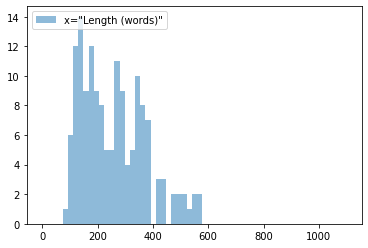

In [ ]:
import matplotlib.pyplot as plt
bins = np.linspace(0, 1100, 60)

plt.hist(df_minute['text_len'], bins, alpha=0.5, label='x="Length (words)"')
plt.legend(loc='upper left')
plt.show()

Frecuencia e Importancia de Palabras: Wordclouds

In [ ]:
from wordcloud import WordCloud,STOPWORDS

In [ ]:
comment_words = ''
stopwords = set(STOPWORDS)


for val in df_minute['text']:


    val = str(val)


    tokens = val.split()

    for i in range(len(tokens)):
        tokens[i] = tokens[i].lower()

    comment_words += " ".join(tokens)+" "

wordcloud = WordCloud(width = 800, height = 800,
                background_color ='white',
                stopwords = stopwords,
                min_font_size = 10).generate(comment_words)

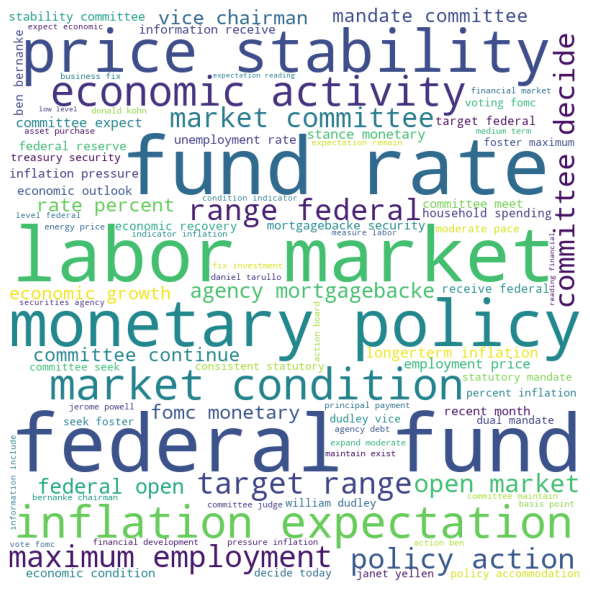

In [ ]:
plt.figure(figsize = (8, 8), facecolor = None)
plt.imshow(wordcloud)
plt.axis("off")
plt.tight_layout(pad = 0)

plt.show()

In [ ]:
nltk.download('wordnet')
from nltk.corpus import wordnet, stopwords
from nltk import FreqDist

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


Esto mismo podemos hacerlo viendo el período de cada uno de los chairman y evaluar la minuta de cada uno de ellos.

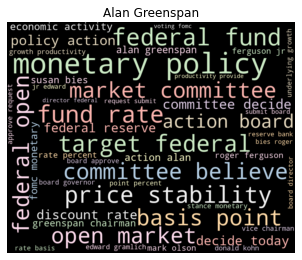

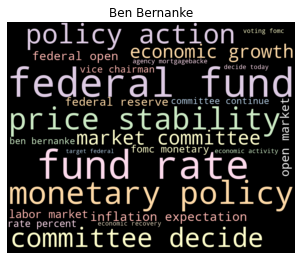

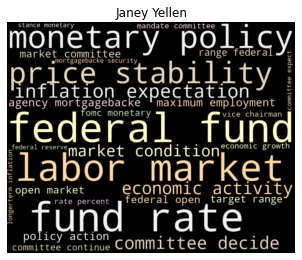

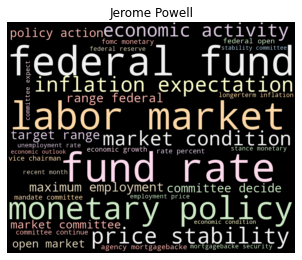

In [ ]:
nombre = df_minute['chairman'].unique()
comment_words = ''
stopwords = set(STOPWORDS)
#stopwords = set(stopwords.words('english'))

for chair in nombre:
  subset = df_minute[df_minute["chairman"] == chair]
  for val in subset['text']:
      val = str(val)
      tokens = val.split()
      for i in range(len(tokens)):
          tokens[i] = tokens[i].lower()

      comment_words += " ".join(tokens)+" "

  wordcloud = WordCloud(width = 1000, height = 800,
                background_color ='black',
                colormap = "Pastel1",
                stopwords = stopwords,
                min_font_size = 20).generate(comment_words)

  plt.figure(figsize = (4, 4), facecolor = None)
  plt.imshow(wordcloud, interpolation="bilinear")
  plt.title(chair)
  plt.axis("off")
  plt.tight_layout(pad = 0)
  plt.show()

Dado el formato de la minuta se observa que las palabras más grandes se repiten.

In [ ]:
for chair in nombre:
  subset = df_minute[df_minute["chairman"] == chair]
  class color:
   PURPLE = '\033[95m'
   CYAN = '\033[96m'
   DARKCYAN = '\033[36m'
   BLUE = '\033[94m'
   GREEN = '\033[92m'
   YELLOW = '\033[93m'
   RED = '\033[91m'
   BOLD = '\033[1m'
   UNDERLINE = '\033[4m'
   END = '\033[0m'
  print(color.BOLD + chair + color.END)
  total = ' '.join(subset["text"])
  lexicalrich(total)

Alan Greenspan
Word count: 6023
Unique term count: 601
0.1
Ben Bernanke
Word count: 17034
Unique term count: 864
0.05
Janey Yellen
Word count: 12147
Unique term count: 552
0.05
Jerome Powell
Word count: 3320
Unique term count: 245
0.07


Vemos que hay una diferencia en la cantidad de palabras distintas usadas en cada minuta del periodo de cada chairman. Ahora, hay alguna diferencia en el largo de sus minutas? Notablemente, Greenspan es el que discursos mas cortos tiene.

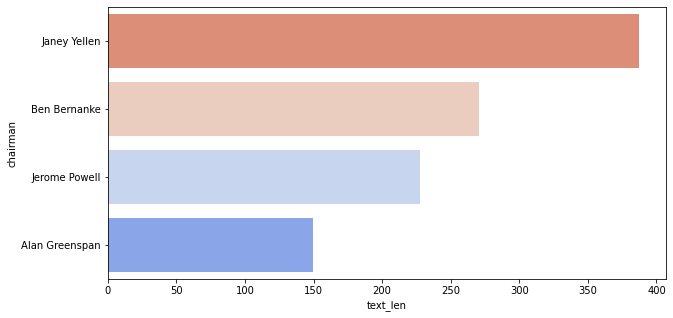

In [ ]:
plt.figure(figsize=(10,5))
grouped = df_minute.groupby(["chairman"])["text_len"].mean()
grouped = grouped.sort_values(ascending=False)
grouped = grouped.to_frame()
grouped = grouped.reset_index()
ax = sns.barplot(x='text_len', y="chairman", data=grouped, palette = "coolwarm_r")

In [ ]:
df_minute['text_len'].describe()

count    152.000000
mean     258.355263
std      116.384918
min       78.000000
25%      159.750000
50%      242.500000
75%      340.000000
max      572.000000
Name: text_len, dtype: float64

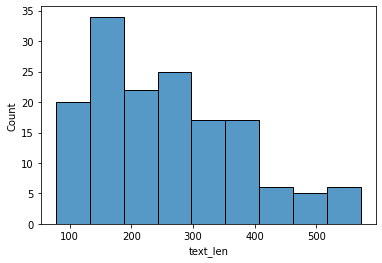

In [ ]:
plt.clf()

sns.histplot(data=df_minute, x="text_len")



## Sentiment Analysis

Usaremos polarity, tener en cuenta que polarity se lee así:


*   '> 0 Positivo

*   < 0 Negativo

In [ ]:
df_minute['polarity'] = df_minute['text'].apply(lambda x: polarity(x))
df_minute["polarity"].describe()

count    152.000000
mean       0.288851
std        0.296692
min       -1.000000
25%        0.117778
50%        0.333333
75%        0.500000
max        0.833333
Name: polarity, dtype: float64

In [ ]:
df_minute.head()

,date,text,chairman,text_len,polarity
0,2001-01-31,federal open market committee meeting today de...,Alan Greenspan,159,0.111111
1,2001-03-20,federal open market committee meeting today de...,Alan Greenspan,145,0.285714
2,2001-05-15,federal open market committee meeting today de...,Alan Greenspan,164,0.300000
3,2001-06-27,federal open market committee meeting today de...,Alan Greenspan,130,0.230769
4,2001-08-21,federal open market committee meeting today de...,Alan Greenspan,127,0.166667


In [ ]:
#Cantidad de minutas con polarity menor a 0.
df_minute[df_minute['polarity'] < 0].shape[0]/152

0.1513157894736842

In [ ]:
#La peor minuta
pd.options.display.max_colwidth = 100
print(list(df_minute[df_minute["polarity"] == -1]["text"]))
df_minute[df_minute['polarity'] == -1]

['share federal open market committee decide today keep target federal fund rate 514 percent economic growth slow first part year adjustment housing sector ongoing nevertheless economy seem likely expand moderate pace come quarter core inflation remain somewhat elevated although inflation pressure seem likely moderate time high level resource utilization potential sustain pressure circumstance committee predominant policy concern remain risk inflation fail moderate expect future policy adjustment depend evolution outlook inflation economic growth imply incoming information voting fomc monetary policy action ben bernanke chairman timothy f geithner vice chairman thomas hoenig donald l kohn randall kroszner cathy e minehan frederic mishkin michael h moskow william poole kevin warsh']


,date,text,chairman,text_len,polarity
50,2007-05-09,share federal open market committee decide today keep target federal fund rate 514 percent econo...,Ben Bernanke,107,-1.0


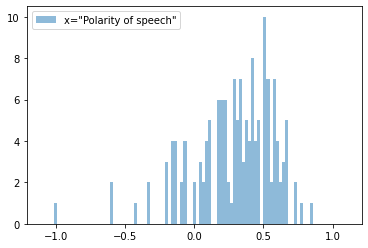

In [ ]:
bins = np.linspace(-1.1, 1.1, 100)

plt.hist(df_minute['polarity'], bins, alpha=0.5, label='x="Polarity of speech"')
plt.legend(loc='upper left')
plt.show()

In [ ]:
len(df_minute['polarity'][df_minute['polarity']<0])

23

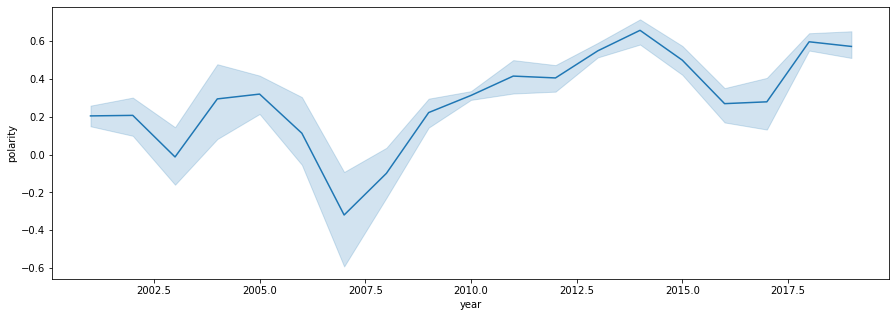

In [ ]:
df_minute['year'] = df_minute['date'].dt.year
plt.figure(figsize=(15,5))
sns.lineplot(data=df_minute, x="year", y="polarity")

Vemos el scoring a lo largo de los años. Tal como esperamos, en la época de 2004-2006 da un scoring alto, así como los periodos 2012-2016, mientras que tiene una bajada muy pronunciada durante la gran recesión de las crisis subprime (2008-2009)

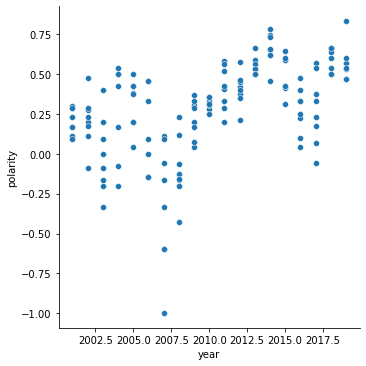

In [ ]:
sns.relplot(data=df_minute, x="year", y="polarity")

In [ ]:
grouped = df_minute.groupby(['year',"chairman"])["polarity"].mean()
pd.set_option('display.max_rows', 1000)
grouped

year  chairman      
2001  Alan Greenspan    0.204694
2002  Alan Greenspan    0.207446
2003  Alan Greenspan   -0.012500
2004  Alan Greenspan    0.294597
2005  Alan Greenspan    0.320030
2006  Alan Greenspan    0.333333
      Ben Bernanke      0.081633
2007  Ben Bernanke     -0.319600
2008  Ben Bernanke     -0.099254
2009  Ben Bernanke      0.222344
2010  Ben Bernanke      0.312900
2011  Ben Bernanke      0.415313
2012  Ben Bernanke      0.405545
2013  Ben Bernanke      0.548841
2014  Ben Bernanke      0.652174
      Janey Yellen      0.658184
2015  Janey Yellen      0.499585
2016  Janey Yellen      0.269506
2017  Janey Yellen      0.279163
2018  Janey Yellen      0.666667
      Jerome Powell     0.586880
2019  Jerome Powell     0.572175
Name: polarity, dtype: float64

In [ ]:
def colapsar(year):
  return ' '.join(df_minute['text'][df_minute['year']== year ])

In [ ]:
def common_words(data, num):
  return FreqDist(nltk.tokenize.word_tokenize(data)).most_common(num)

In [ ]:
speechesde2009  = common_words(colapsar(2009), 20)
speechesde2009

[('federal', 59),
 ('market', 57),
 ('committee', 54),
 ('economic', 53),
 ('continue', 34),
 ('reserve', 34),
 ('condition', 31),
 ('financial', 29),
 ('purchase', 29),
 ('credit', 28),
 ('security', 28),
 ('l', 24),
 ('remain', 23),
 ('rate', 22),
 ('time', 22),
 ('anticipate', 21),
 ('likely', 21),
 ('price', 20),
 ('housing', 19),
 ('agency', 19)]

In [ ]:
def plot_most_common_words(data, year):
  fig = plt.figure(figsize=(15, 6))
  fig.suptitle("Most common words in Speechs of "+str(year))


      # left subplot without stop words
  sns.barplot(x=[x[0] for x in data],y=[x[1] for x in data],  color='lightseagreen')
  fig.autofmt_xdate(rotation=45)

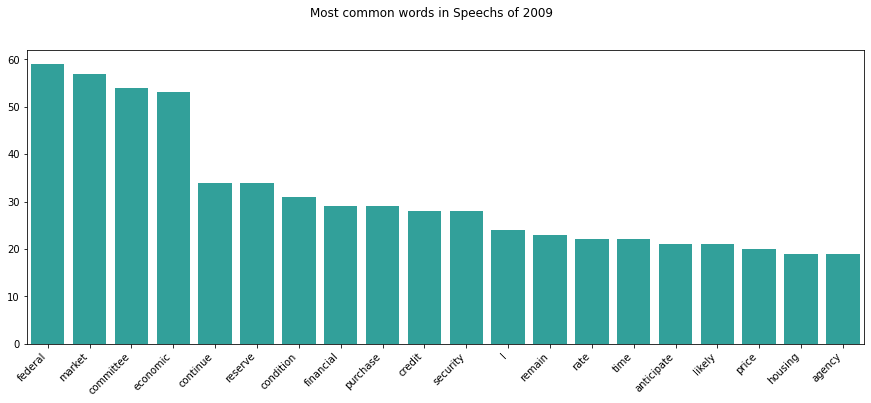

In [ ]:
plot_most_common_words(speechesde2009, 2009)

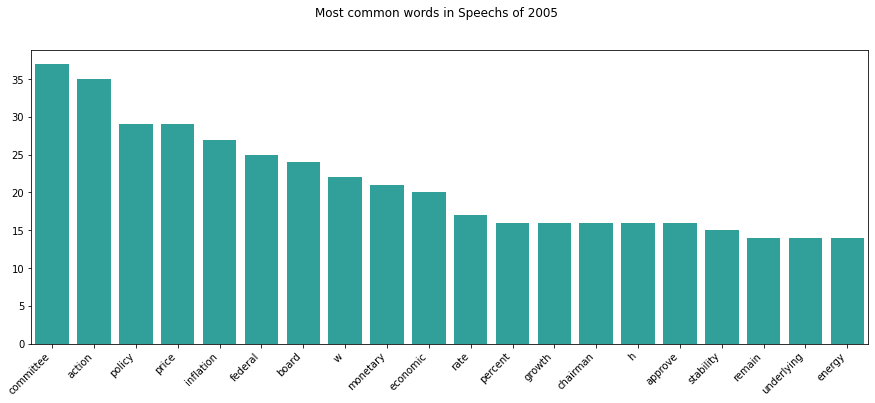

In [ ]:
speechesde2005 = common_words(colapsar(2005), 20)
plot_most_common_words(speechesde2005, 2005)

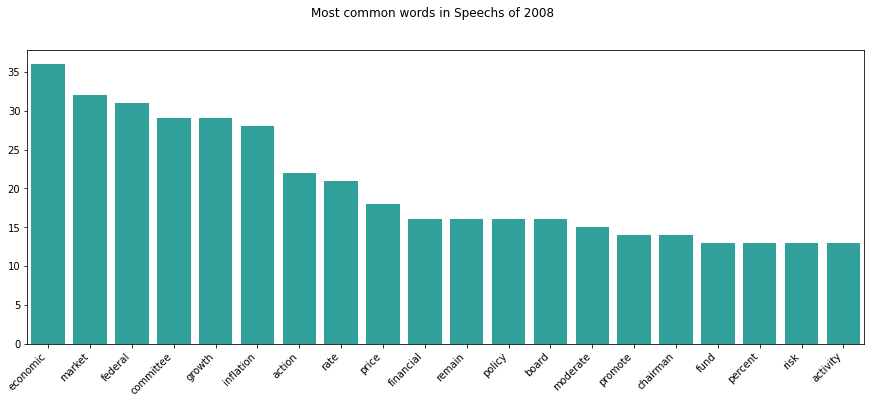

In [ ]:
speechesde2008 = common_words(colapsar(2008), 20)
plot_most_common_words(speechesde2008, 2008)

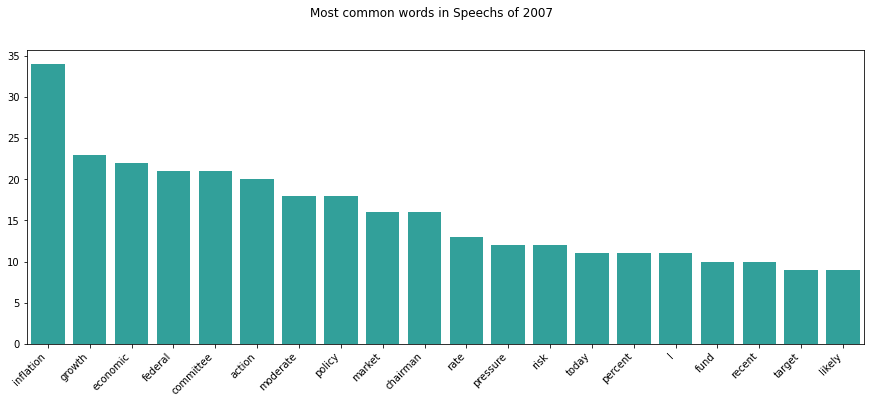

In [ ]:
speechesde2007 = common_words(colapsar(2007), 20)
plot_most_common_words(speechesde2007, 2007)

Se observa que en contra posición a los speeches los most common words no nos dan un resultado contundente.

## Entrenamiento y Clasificación

### Volatilidad

In [ ]:
df_minute_vix = df_minute.merge(base, how = 'left', left_on = 'date', right_on = 'Dates')

5 días

In [ ]:
#Armo las categorias de volatilidad

df_minute_vix['category_t5'] = np.where(df_minute_vix['change_t5']>0, 1, 0)
df_minute_vix['category_t10'] = np.where(df_minute_vix['change_t10']>0, 1, 0)
df_minute_vix['category_t20'] = np.where(df_minute_vix['change_t20']>0, 1, 0)
df_minute_vix['category_t50'] = np.where(df_minute_vix['change_t50']>0, 1, 0)
df_minute_vix['category_t100'] = np.where(df_minute_vix['change_t100']>0, 1, 0)

In [ ]:
df_minute_vix.head()

,date,text,chairman,text_len,polarity,year,Dates,VIX_Index,GT10 Govt,GT2 Govt,GT30 Govt,GT5 Govt,change_gt2_t1,change_gt2_t3,change_gt2_t5,change_gt2_t10,change_gt2_t20,change_gt2_t50,change_gt2_t100,change_t1,change_t2,change_t3,change_t5,change_t10,change_t20,change_t50,change_t100,previous_vix,weekday,category_t5,category_t10,category_t20,category_t50,category_t100
0,2001-01-31,federal open market committee meeting today decide low target federal fund rate 50 basis point 5...,Alan Greenspan,159,0.111111,2001,2001-01-31,22.02,5.114,4.572,5.501,4.768,-0.017,0.098,0.148,0.283,-0.182,-0.302,-0.623,-0.36,-0.07,0.17,-0.35,-0.50,6.33,6.44,-0.31,23.399333,2,0,0,1,1,0
1,2001-03-20,federal open market committee meeting today decide low target federal fund rate 50 basis point 5...,Alan Greenspan,145,0.285714,2001,2001-03-20,30.96,4.758,4.205,5.260,4.451,0.008,0.056,0.208,-0.083,0.226,0.107,-0.335,0.97,1.88,-0.51,-3.92,3.76,-5.35,-8.82,-9.95,27.839333,1,0,1,0,0,0
2,2001-05-15,federal open market committee meeting today decide low target federal fund rate 50 basis point 4...,Alan Greenspan,164,0.300000,2001,2001-05-15,23.71,5.512,4.239,5.911,4.966,-0.008,0.120,0.087,0.073,-0.178,-0.302,-1.493,-1.82,-2.24,-2.48,-2.36,-1.57,-3.01,1.53,7.47,24.676000,1,0,0,0,1,1
3,2001-06-27,federal open market committee meeting today decide low target federal fund rate 25 basis point 3...,Alan Greenspan,130,0.230769,2001,2001-06-27,20.88,5.235,4.108,5.618,4.789,0.101,0.060,0.128,-0.054,-0.128,-0.339,-1.395,-0.87,-1.82,-2.12,-1.96,3.13,3.12,5.47,5.68,21.182667,2,0,1,1,1,1
4,2001-08-21,federal open market committee meeting today decide low target federal fund rate 25 basis point 3...,Alan Greenspan,127,0.166667,2001,2001-08-21,24.40,4.864,3.676,5.432,4.418,0.050,0.092,-0.010,0.118,-0.729,-1.228,-0.619,-1.96,-2.17,-4.69,-2.40,1.45,14.47,9.06,-2.57,21.501333,1,0,1,1,1,0


In [ ]:
x,y=df_minute_vix.iloc[:,1],df_minute_vix.iloc[:,29]

x_train,x_test,y_train,y_test=train_test_split(x,y,train_size=0.8,test_size=0.2,random_state=123)
y_train.head()

4      0
53     0
135    0
29     1
72     0
Name: category_t5, dtype: int64

In [ ]:
x_train.reset_index(drop = True, inplace = True)
y_train.reset_index(drop = True, inplace = True)
x_test.reset_index(drop = True, inplace = True)
y_test.reset_index(drop = True, inplace = True)
y_test=y_test.astype('int')
y_train=y_train.astype('int')
y_train.head()

0    0
1    0
2    0
3    1
4    0
Name: category_t5, dtype: int64

In [ ]:
vectorizer = TfidfVectorizer()
X_train = vectorizer.fit_transform(x_train)
X_test = vectorizer.transform(x_test)

In [ ]:
tuned_parameters = [{'kernel': ['rbf'],'C': [0.1,1,5, 10, 25]},
                    {'kernel': ['linear'], 'C': [0.1, 1, 5,10, 25]}]

svm = GridSearchCV(SVC(), tuned_parameters, cv=5)
svm.fit(X_train, y_train)
print(svm.best_score_)
print(svm.best_estimator_)
print(svm.best_params_)
svm_clf_scores = cross_val_score(svm.best_estimator_, X_train, y_train, cv=5)
print(svm_clf_scores)
print("Accuracy: %0.2f (+/- %0.2f)" % (svm_clf_scores.mean(), svm_clf_scores.std() * 2))

0.5459999999999999
SVC(C=5, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='scale', kernel='rbf',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)
{'C': 5, 'kernel': 'rbf'}
[0.48       0.66666667 0.45833333 0.58333333 0.54166667]
Accuracy: 0.55 (+/- 0.15)


In [ ]:
    print("Detailed classification report:")
    print()
    y_true_vol5, y_pred_vol5 = y_test, svm.predict(X_test)
    print(classification_report(y_true_vol5, y_pred_vol5))
    print()

Detailed classification report:

              precision    recall  f1-score   support

           0       0.47      0.47      0.47        15
           1       0.50      0.50      0.50        16

    accuracy                           0.48        31
   macro avg       0.48      0.48      0.48        31
weighted avg       0.48      0.48      0.48        31




20 días

In [ ]:
x,y=df_minute_vix.iloc[:,1],df_minute_vix.iloc[:,31]

x_train,x_test,y_train,y_test=train_test_split(x,y,train_size=0.8,test_size=0.2,random_state=123)
y_train.head()
x_train.reset_index(drop = True, inplace = True)
y_train.reset_index(drop = True, inplace = True)
x_test.reset_index(drop = True, inplace = True)
y_test.reset_index(drop = True, inplace = True)
y_test=y_test.astype('int')
y_train=y_train.astype('int')
y_train.head()

0    1
1    0
2    0
3    1
4    0
Name: category_t20, dtype: int64

In [ ]:
vectorizer = TfidfVectorizer()
X_train = vectorizer.fit_transform(x_train)
X_test = vectorizer.transform(x_test)
tuned_parameters = [{'kernel': ['rbf'],'C': [0.1,1,5, 10, 25]},
                    {'kernel': ['linear'], 'C': [0.1, 1, 5,10, 25]}]

svm = GridSearchCV(SVC(), tuned_parameters, cv=5)
svm.fit(X_train, y_train)
print(svm.best_score_)
print(svm.best_estimator_)
print(svm.best_params_)
svm_clf_scores = cross_val_score(svm.best_estimator_, X_train, y_train, cv=5)
print(svm_clf_scores)
print("Accuracy: %0.2f (+/- %0.2f)" % (svm_clf_scores.mean(), svm_clf_scores.std() * 2))

0.5710000000000001
SVC(C=1, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='scale', kernel='rbf',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)
{'C': 1, 'kernel': 'rbf'}
[0.48       0.625      0.58333333 0.58333333 0.58333333]
Accuracy: 0.57 (+/- 0.10)


In [ ]:
    print("Detailed classification report:")
    print()
    y_true_vol20, y_pred_vol20 = y_test, svm.predict(X_test)
    print(classification_report(y_true_vol20, y_pred_vol20))
    print()

Detailed classification report:

              precision    recall  f1-score   support

           0       0.46      0.81      0.59        16
           1       0.00      0.00      0.00        15

    accuracy                           0.42        31
   macro avg       0.23      0.41      0.30        31
weighted avg       0.24      0.42      0.30        31




50 días

In [ ]:
x,y=df_minute_vix.iloc[:,1],df_minute_vix.iloc[:,32]

x_train,x_test,y_train,y_test=train_test_split(x,y,train_size=0.8,test_size=0.2,random_state=123)
y_train.head()
x_train.reset_index(drop = True, inplace = True)
y_train.reset_index(drop = True, inplace = True)
x_test.reset_index(drop = True, inplace = True)
y_test.reset_index(drop = True, inplace = True)
y_test=y_test.astype('int')
y_train=y_train.astype('int')
y_train.head()

0    1
1    1
2    1
3    0
4    0
Name: category_t50, dtype: int64

In [ ]:
vectorizer = TfidfVectorizer()
X_train = vectorizer.fit_transform(x_train)
X_test = vectorizer.transform(x_test)
tuned_parameters = [{'kernel': ['rbf'],'C': [0.1,1,5, 10, 25]},
                    {'kernel': ['linear'], 'C': [0.1, 1, 5,10, 25]}]

svm = GridSearchCV(SVC(), tuned_parameters, cv=5)
svm.fit(X_train, y_train)
print(svm.best_score_)
print(svm.best_estimator_)
print(svm.best_params_)
svm_clf_scores = cross_val_score(svm.best_estimator_, X_train, y_train, cv=5)
print(svm_clf_scores)
print("Accuracy: %0.2f (+/- %0.2f)" % (svm_clf_scores.mean(), svm_clf_scores.std() * 2))

0.6023333333333334
SVC(C=25, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='scale', kernel='rbf',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)
{'C': 25, 'kernel': 'rbf'}
[0.72       0.5        0.625      0.58333333 0.58333333]
Accuracy: 0.60 (+/- 0.14)


In [ ]:
    print("Detailed classification report:")
    print()
    y_true_vol50, y_pred_vol50 = y_test, svm.predict(X_test)
    print(classification_report(y_true_vol50, y_pred_vol50))
    print()

Detailed classification report:

              precision    recall  f1-score   support

           0       0.75      0.67      0.71        18
           1       0.60      0.69      0.64        13

    accuracy                           0.68        31
   macro avg       0.68      0.68      0.67        31
weighted avg       0.69      0.68      0.68        31




100 días

In [ ]:
x,y=df_minute_vix.iloc[:,1],df_minute_vix.iloc[:,33]

x_train,x_test,y_train,y_test=train_test_split(x,y,train_size=0.8,test_size=0.2,random_state=123)
y_train.head()
x_train.reset_index(drop = True, inplace = True)
y_train.reset_index(drop = True, inplace = True)
x_test.reset_index(drop = True, inplace = True)
y_test.reset_index(drop = True, inplace = True)
y_test=y_test.astype('int')
y_train=y_train.astype('int')
y_train.head()

0    0
1    1
2    1
3    0
4    1
Name: category_t100, dtype: int64

In [ ]:
vectorizer = TfidfVectorizer()
X_train = vectorizer.fit_transform(x_train)
X_test = vectorizer.transform(x_test)
tuned_parameters = [{'kernel': ['rbf'],'C': [0.1,1,5, 10, 25]},
                    {'kernel': ['linear'], 'C': [0.1, 1, 5,10, 25]}]

svm = GridSearchCV(SVC(), tuned_parameters, cv=5)
svm.fit(X_train, y_train)
print(svm.best_score_)
print(svm.best_estimator_)
print(svm.best_params_)
svm_clf_scores = cross_val_score(svm.best_estimator_, X_train, y_train, cv=5)
print(svm_clf_scores)
print("Accuracy: %0.2f (+/- %0.2f)" % (svm_clf_scores.mean(), svm_clf_scores.std() * 2))

0.67
SVC(C=25, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='scale', kernel='rbf',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)
{'C': 25, 'kernel': 'rbf'}
[0.6        0.75       0.75       0.66666667 0.58333333]
Accuracy: 0.67 (+/- 0.14)


In [ ]:
    print("Detailed classification report:")
    print()
    y_true_vol100, y_pred_vol100 = y_test, svm.predict(X_test)
    print(classification_report(y_true_vol100, y_pred_vol100))
    print()

Detailed classification report:

              precision    recall  f1-score   support

           0       0.74      0.94      0.83        18
           1       0.88      0.54      0.67        13

    accuracy                           0.77        31
   macro avg       0.81      0.74      0.75        31
weighted avg       0.80      0.77      0.76        31




In [ ]:
df_bonos = df_minute.merge(base_bonos, how = 'left', left_on = 'date', right_on = 'Dates')
df_bonos.head()

,date,text,chairman,text_len,polarity,year,Dates,VIX Index,GT10 Govt,GT2 Govt,GT30 Govt,GT5 Govt,change_gt2_t1,change_gt2_t3,change_gt2_t5,change_gt2_t10,change_gt2_t20,change_gt2_t50,change_gt2_t100,change_t1,change_t2,change_t3,change_t5,change_t10,change_t20,change_t50,change_t100
0,2001-01-31,federal open market committee meeting today decide low target federal fund rate 50 basis point 5...,Alan Greenspan,159,0.111111,2001,2001-01-31,22.02,5.114,4.572,5.501,4.768,-0.017,0.098,0.148,0.283,-0.182,-0.302,-0.623,-0.36,-0.07,0.17,-0.35,-0.50,6.33,6.44,-0.31
1,2001-03-20,federal open market committee meeting today decide low target federal fund rate 50 basis point 5...,Alan Greenspan,145,0.285714,2001,2001-03-20,30.96,4.758,4.205,5.260,4.451,0.008,0.056,0.208,-0.083,0.226,0.107,-0.335,0.97,1.88,-0.51,-3.92,3.76,-5.35,-8.82,-9.95
2,2001-05-15,federal open market committee meeting today decide low target federal fund rate 50 basis point 4...,Alan Greenspan,164,0.300000,2001,2001-05-15,23.71,5.512,4.239,5.911,4.966,-0.008,0.120,0.087,0.073,-0.178,-0.302,-1.493,-1.82,-2.24,-2.48,-2.36,-1.57,-3.01,1.53,7.47
3,2001-06-27,federal open market committee meeting today decide low target federal fund rate 25 basis point 3...,Alan Greenspan,130,0.230769,2001,2001-06-27,20.88,5.235,4.108,5.618,4.789,0.101,0.060,0.128,-0.054,-0.128,-0.339,-1.395,-0.87,-1.82,-2.12,-1.96,3.13,3.12,5.47,5.68
4,2001-08-21,federal open market committee meeting today decide low target federal fund rate 25 basis point 3...,Alan Greenspan,127,0.166667,2001,2001-08-21,24.40,4.864,3.676,5.432,4.418,0.050,0.092,-0.010,0.118,-0.729,-1.228,-0.619,-1.96,-2.17,-4.69,-2.40,1.45,14.47,9.06,-2.57


### Treasury Bonds


10 Días

In [ ]:
df_bonos['categorygt2_t20'] = np.where(df_bonos['change_gt2_t20']>0, 1, 0)
df_bonos['categorygt2_t10'] = np.where(df_bonos['change_gt2_t10']>0, 1, 0)

In [ ]:
df_bonos.head()

,date,text,chairman,text_len,polarity,year,Dates,VIX Index,GT10 Govt,GT2 Govt,GT30 Govt,GT5 Govt,change_gt2_t1,change_gt2_t3,change_gt2_t5,change_gt2_t10,change_gt2_t20,change_gt2_t50,change_gt2_t100,change_t1,change_t2,change_t3,change_t5,change_t10,change_t20,change_t50,change_t100,categorygt2_t20,categorygt2_t10
0,2001-01-31,federal open market committee meeting today decide low target federal fund rate 50 basis point 5...,Alan Greenspan,159,0.111111,2001,2001-01-31,22.02,5.114,4.572,5.501,4.768,-0.017,0.098,0.148,0.283,-0.182,-0.302,-0.623,-0.36,-0.07,0.17,-0.35,-0.50,6.33,6.44,-0.31,0,1
1,2001-03-20,federal open market committee meeting today decide low target federal fund rate 50 basis point 5...,Alan Greenspan,145,0.285714,2001,2001-03-20,30.96,4.758,4.205,5.260,4.451,0.008,0.056,0.208,-0.083,0.226,0.107,-0.335,0.97,1.88,-0.51,-3.92,3.76,-5.35,-8.82,-9.95,1,0
2,2001-05-15,federal open market committee meeting today decide low target federal fund rate 50 basis point 4...,Alan Greenspan,164,0.300000,2001,2001-05-15,23.71,5.512,4.239,5.911,4.966,-0.008,0.120,0.087,0.073,-0.178,-0.302,-1.493,-1.82,-2.24,-2.48,-2.36,-1.57,-3.01,1.53,7.47,0,1
3,2001-06-27,federal open market committee meeting today decide low target federal fund rate 25 basis point 3...,Alan Greenspan,130,0.230769,2001,2001-06-27,20.88,5.235,4.108,5.618,4.789,0.101,0.060,0.128,-0.054,-0.128,-0.339,-1.395,-0.87,-1.82,-2.12,-1.96,3.13,3.12,5.47,5.68,0,0
4,2001-08-21,federal open market committee meeting today decide low target federal fund rate 25 basis point 3...,Alan Greenspan,127,0.166667,2001,2001-08-21,24.40,4.864,3.676,5.432,4.418,0.050,0.092,-0.010,0.118,-0.729,-1.228,-0.619,-1.96,-2.17,-4.69,-2.40,1.45,14.47,9.06,-2.57,0,1


In [ ]:
x,y=df_bonos.iloc[:,1],df_bonos.iloc[:,28]

x_train,x_test,y_train,y_test=train_test_split(x,y,train_size=0.8,test_size=0.2,random_state=123)
x_train.reset_index(drop = True, inplace = True)
y_train.reset_index(drop = True, inplace = True)
x_test.reset_index(drop = True, inplace = True)
x_test.reset_index(drop = True, inplace = True)
y_test = y_test.astype('int')
y_train = y_train.astype('int')
y_train.head()

0    1
1    0
2    1
3    1
4    0
Name: categorygt2_t10, dtype: int64

In [ ]:
len(y_test)

31

In [ ]:
vectorizer = TfidfVectorizer()
X_train = vectorizer.fit_transform(x_train)
X_test = vectorizer.transform(x_test)
tuned_parameters = [{'kernel': ['rbf'],'C': [0.1,1,5, 10, 25]},
                    {'kernel': ['linear'], 'C': [0.1, 1, 5, 10, 25]}]

svm = GridSearchCV(SVC(), tuned_parameters, cv=5)
svm.fit(X_train, y_train)
print(svm.best_score_)
print(svm.best_estimator_)
print(svm.best_params_)
svm_clf_scores = cross_val_score(svm.best_estimator_, X_train, y_train, cv=5)
print(svm_clf_scores)
print("Accuracy: %0.2f (+/- %0.2f)" % (svm_clf_scores.mean(), svm_clf_scores.std() * 2))

0.58
SVC(C=25, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='scale', kernel='rbf',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)
{'C': 25, 'kernel': 'rbf'}
[0.4        0.66666667 0.625      0.54166667 0.66666667]
Accuracy: 0.58 (+/- 0.20)


In [ ]:
    print("Detailed classification report:")
    print()
    print("The model is trained on the full development set.")
    print("The scores are computed on the full evaluation set.")
    print()
    y_true_bono10, y_pred_bono10 = y_test, svm.predict(X_test)
    print(classification_report(y_true_bono10, y_pred_bono10))
    print()

Detailed classification report:

The model is trained on the full development set.
The scores are computed on the full evaluation set.

              precision    recall  f1-score   support

           0       0.50      0.33      0.40        18
           1       0.37      0.54      0.44        13

    accuracy                           0.42        31
   macro avg       0.43      0.44      0.42        31
weighted avg       0.44      0.42      0.42        31




### Fed Rates

In [ ]:
fed = pd.read_csv('DFF.csv')
fed.head()

,DATE,DFF
0,2001-01-01,5.41
1,2001-01-02,6.67
2,2001-01-03,6.35
3,2001-01-04,5.92
4,2001-01-05,5.83


In [ ]:
fed['DATE'] =  pd.to_datetime(fed['DATE'])

In [ ]:
fed['change_fed_t5'] = fed['DFF'].diff(-5)*(-1)
fed['change_fed_t20'] = fed['DFF'].diff(-20)*(-1)
fed['change_fed_t50'] = fed['DFF'].diff(-50)*(-1)
fed['change_fed_t100'] = fed['DFF'].diff(-100)*(-1)

fed['categoryfed_t5'] = np.where(fed['change_fed_t5']> 0, 1, 0)
fed['categoryfed_t20'] = np.where(fed['change_fed_t20']> 0, 1, 0)
fed['categoryfed_t50'] = np.where(fed['change_fed_t50']> 0, 1, 0)
fed['categoryfed_t100'] = np.where(fed['change_fed_t100']> 0, 1, 0)

In [ ]:
fed.head(10)

,DATE,DFF,change_fed_t5,change_fed_t20,change_fed_t50,change_fed_t100,categoryfed_t5,categoryfed_t20,categoryfed_t50,categoryfed_t100
0,2001-01-01,5.41,0.42,0.51,0.16,-0.46,1,1,1,0
1,2001-01-02,6.67,-0.84,-0.67,-1.17,-1.65,0,0,0,0
2,2001-01-03,6.35,-0.37,-0.38,-0.83,-1.34,0,0,0,0
3,2001-01-04,5.92,0.03,0.13,-0.46,-0.91,1,1,0,0
4,2001-01-05,5.83,0.23,0.27,-0.37,-0.82,1,1,0,0
5,2001-01-06,5.83,0.22,0.13,-0.37,-0.66,1,1,0,0
6,2001-01-07,5.83,0.15,0.13,-0.28,-0.84,1,1,0,0
7,2001-01-08,5.98,-0.00,-0.02,-0.49,-1.31,0,0,0,0
8,2001-01-09,5.95,0.03,0.03,-0.36,-1.48,1,1,0,0
9,2001-01-10,6.06,-0.08,-0.16,-0.47,-1.68,0,0,0,0


In [ ]:
df_fed = df_minute.merge(fed, how = 'left', left_on = 'date', right_on = 'DATE')
df_fed.head(10)

,date,text,chairman,text_len,polarity,year,DATE,DFF,change_fed_t5,change_fed_t20,change_fed_t50,change_fed_t100,categoryfed_t5,categoryfed_t20,categoryfed_t50,categoryfed_t100
0,2001-01-31,federal open market committee meeting today decide low target federal fund rate 50 basis point 5...,Alan Greenspan,159,0.111111,2001,2001-01-31,5.74,-0.22,-0.17,-0.70,-1.27,0,0,0,0
1,2001-03-20,federal open market committee meeting today decide low target federal fund rate 50 basis point 5...,Alan Greenspan,145,0.285714,2001,2001-03-20,5.14,-0.20,-0.16,-0.71,-1.28,0,0,0,0
2,2001-05-15,federal open market committee meeting today decide low target federal fund rate 50 basis point 4...,Alan Greenspan,164,0.300000,2001,2001-05-15,4.22,-0.27,-0.19,-0.53,-0.67,0,0,0,0
3,2001-06-27,federal open market committee meeting today decide low target federal fund rate 25 basis point 3...,Alan Greenspan,130,0.230769,2001,2001-06-27,3.68,0.43,0.03,0.07,-1.26,1,1,1,0
4,2001-08-21,federal open market committee meeting today decide low target federal fund rate 25 basis point 3...,Alan Greenspan,127,0.166667,2001,2001-08-21,3.53,-0.02,-0.03,-1.11,-1.44,0,0,0,0
5,2001-10-02,federal open market committee decide today low target federal fund rate 50 basis point 212 perce...,Alan Greenspan,109,0.090909,2001,2001-10-02,2.35,0.07,0.17,-0.42,-0.54,1,1,0,0
6,2001-11-06,federal open market committee decide today low target federal fund rate 50 basis point 2 percent...,Alan Greenspan,105,0.166667,2001,2001-11-06,2.13,-0.15,-0.09,-0.24,-0.32,0,0,0,0
7,2001-12-11,federal open market committee decide today low target federal fund rate 25 basis point 134 perce...,Alan Greenspan,122,0.285714,2001,2001-12-11,1.80,0.08,-0.28,-0.02,-0.06,1,0,0,0
8,2002-01-30,federal open market committee decide today keep target federal fund rate unchanged 134 percent s...,Alan Greenspan,78,0.200000,2002,2002-01-30,1.78,-0.04,-0.01,-0.04,-0.04,0,0,0,0
9,2002-03-19,federal open market committee decide today keep target federal fund rate unchanged 134 percent i...,Alan Greenspan,154,0.176471,2002,2002-03-19,1.67,0.01,0.05,0.04,0.14,1,1,1,1


5 días

In [ ]:
x,y=df_fed.iloc[:,1],df_fed.iloc[:,12]

x_train,x_test,y_train,y_test=train_test_split(x,y,train_size=0.8,test_size=0.2,random_state=123)
x_train.reset_index(drop = True, inplace = True)
y_train.reset_index(drop = True, inplace = True)
x_test.reset_index(drop = True, inplace = True)
y_test.reset_index(drop = True, inplace = True)
y_train=y_train.astype('int')
y_test=y_test.astype('int')
y_train.head()

0    0
1    0
2    1
3    1
4    1
Name: categoryfed_t5, dtype: int64

In [ ]:
vectorizer = TfidfVectorizer()
X_train = vectorizer.fit_transform(x_train)
X_test = vectorizer.transform(x_test)
tuned_parameters = [{'kernel': ['rbf'],'C': [0.1,1,5, 10, 25]},
                    {'kernel': ['linear'], 'C': [0.1, 1,5, 10, 25]}]

svm = GridSearchCV(SVC(), tuned_parameters, cv=5)
svm.fit(X_train, y_train)
print(svm.best_score_)
print(svm.best_estimator_)
print(svm.best_params_)
svm_clf_scores = cross_val_score(svm.best_estimator_, X_train, y_train, cv=5)
print(svm_clf_scores)
print("Accuracy: %0.2f (+/- %0.2f)" % (svm_clf_scores.mean(), svm_clf_scores.std() * 2))

0.6689999999999999
SVC(C=10, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='scale', kernel='linear',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)
{'C': 10, 'kernel': 'linear'}
[0.72       0.66666667 0.54166667 0.66666667 0.75      ]
Accuracy: 0.67 (+/- 0.14)


In [ ]:
    print("Detailed classification report:")
    print()
    print("The model is trained on the full development set.")
    print("The scores are computed on the full evaluation set.")
    print()
    y_true_fed5, y_pred_fed5 = y_test, svm.predict(X_test)
    print(classification_report(y_true_fed5, y_pred_fed5))
    print()

Detailed classification report:

The model is trained on the full development set.
The scores are computed on the full evaluation set.

              precision    recall  f1-score   support

           0       0.30      0.60      0.40        10
           1       0.64      0.33      0.44        21

    accuracy                           0.42        31
   macro avg       0.47      0.47      0.42        31
weighted avg       0.53      0.42      0.43        31




20 días

In [ ]:
x,y=df_fed.iloc[:,1],df_fed.iloc[:,13]

x_train,x_test,y_train,y_test=train_test_split(x,y,train_size=0.8,test_size=0.2,random_state=123)
x_train.reset_index(drop = True, inplace = True)
y_train.reset_index(drop = True, inplace = True)
x_test.reset_index(drop = True, inplace = True)
y_test.reset_index(drop = True, inplace = True)
y_train=y_train.astype('int')
y_test=y_test.astype('int')
y_train.head()

0    0
1    0
2    1
3    1
4    1
Name: categoryfed_t20, dtype: int64

In [ ]:
vectorizer = TfidfVectorizer()
X_train = vectorizer.fit_transform(x_train)
X_test = vectorizer.transform(x_test)
tuned_parameters = [{'kernel': ['rbf'],'C': [0.1,1,5, 10, 25]},
                    {'kernel': ['linear'], 'C': [0.1, 1,5, 10, 25]}]

svm = GridSearchCV(SVC(), tuned_parameters, cv=5)
svm.fit(X_train, y_train)
print(svm.best_score_)
print(svm.best_estimator_)
print(svm.best_params_)
svm_clf_scores = cross_val_score(svm.best_estimator_, X_train, y_train, cv=5)
print(svm_clf_scores)
print("Accuracy: %0.2f (+/- %0.2f)" % (svm_clf_scores.mean(), svm_clf_scores.std() * 2))

0.6946666666666668
SVC(C=1, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='scale', kernel='linear',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)
{'C': 1, 'kernel': 'linear'}
[0.64       0.79166667 0.58333333 0.75       0.70833333]
Accuracy: 0.69 (+/- 0.15)


In [ ]:
    print("Detailed classification report:")
    print()
    print("The model is trained on the full development set.")
    print("The scores are computed on the full evaluation set.")
    print()
    y_true_fed20, y_pred_fed20 = y_test, svm.predict(X_test)
    print(classification_report(y_true_fed20, y_pred_fed20))
    print()

Detailed classification report:

The model is trained on the full development set.
The scores are computed on the full evaluation set.

              precision    recall  f1-score   support

           0       0.43      0.91      0.59        11
           1       0.88      0.35      0.50        20

    accuracy                           0.55        31
   macro avg       0.65      0.63      0.54        31
weighted avg       0.72      0.55      0.53        31




50 días

In [ ]:
x,y=df_fed.iloc[:,1],df_fed.iloc[:,14]

x_train,x_test,y_train,y_test=train_test_split(x,y,train_size=0.8,test_size=0.2,random_state=123)
x_train.reset_index(drop = True, inplace = True)
y_train.reset_index(drop = True, inplace = True)
x_test.reset_index(drop = True, inplace = True)
y_test.reset_index(drop = True, inplace = True)
y_train=y_train.astype('int')
y_test=y_test.astype('int')
y_train.head()

0    0
1    0
2    1
3    1
4    1
Name: categoryfed_t50, dtype: int64

In [ ]:
vectorizer = TfidfVectorizer()
X_train = vectorizer.fit_transform(x_train)
X_test = vectorizer.transform(x_test)
tuned_parameters = [{'kernel': ['rbf'],'C': [0.1,1,5, 10, 25]},
                    {'kernel': ['linear'], 'C': [0.1, 1,5, 10, 25]}]

svm = GridSearchCV(SVC(), tuned_parameters, cv=5)
svm.fit(X_train, y_train)
print(svm.best_score_)
print(svm.best_estimator_)
print(svm.best_params_)
svm_clf_scores = cross_val_score(svm.best_estimator_, X_train, y_train, cv=5)
print(svm_clf_scores)
print("Accuracy: %0.2f (+/- %0.2f)" % (svm_clf_scores.mean(), svm_clf_scores.std() * 2))

0.7026666666666668
SVC(C=1, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='scale', kernel='linear',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)
{'C': 1, 'kernel': 'linear'}
[0.68       0.70833333 0.75       0.625      0.75      ]
Accuracy: 0.70 (+/- 0.09)


In [ ]:
    print("Detailed classification report:")
    print()
    print("The model is trained on the full development set.")
    print("The scores are computed on the full evaluation set.")
    print()
    y_true_fed50, y_pred_fed50 = y_test, svm.predict(X_test)
    print(classification_report(y_true_fed50, y_pred_fed50))
    print()

Detailed classification report:

The model is trained on the full development set.
The scores are computed on the full evaluation set.

              precision    recall  f1-score   support

           0       0.62      0.80      0.70        10
           1       0.89      0.76      0.82        21

    accuracy                           0.77        31
   macro avg       0.75      0.78      0.76        31
weighted avg       0.80      0.77      0.78        31




100 dias

In [ ]:
x,y=df_fed.iloc[:,1],df_fed.iloc[:,15]

x_train,x_test,y_train,y_test=train_test_split(x,y,train_size=0.8,test_size=0.2,random_state=123)
x_train.reset_index(drop = True, inplace = True)
y_train.reset_index(drop = True, inplace = True)
x_test.reset_index(drop = True, inplace = True)
y_test.reset_index(drop = True, inplace = True)
y_train=y_train.astype('int')
y_test=y_test.astype('int')
y_train.head()

0    0
1    0
2    1
3    1
4    1
Name: categoryfed_t100, dtype: int64

In [ ]:
vectorizer = TfidfVectorizer()
X_train = vectorizer.fit_transform(x_train)
X_test = vectorizer.transform(x_test)
tuned_parameters = [{'kernel': ['rbf'],'C': [0.1,1,5, 10, 25]},
                    {'kernel': ['linear'], 'C': [0.1, 1,5, 10, 25]}]

svm = GridSearchCV(SVC(), tuned_parameters, cv=5)
svm.fit(X_train, y_train)
print(svm.best_score_)
print(svm.best_estimator_)
print(svm.best_params_)
svm_clf_scores = cross_val_score(svm.best_estimator_, X_train, y_train, cv=5)
print(svm_clf_scores)
print("Accuracy: %0.2f (+/- %0.2f)" % (svm_clf_scores.mean(), svm_clf_scores.std() * 2))

0.7766666666666666
SVC(C=1, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='scale', kernel='linear',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)
{'C': 1, 'kernel': 'linear'}
[0.8        0.75       0.75       0.75       0.83333333]
Accuracy: 0.78 (+/- 0.07)


In [ ]:
    print("Detailed classification report:")
    print()
    print("The model is trained on the full development set.")
    print("The scores are computed on the full evaluation set.")
    print()
    y_true_fed100, y_pred_fed100 = y_test, svm.predict(X_test)
    print(classification_report(y_true_fed100, y_pred_fed100))
    print()

Detailed classification report:

The model is trained on the full development set.
The scores are computed on the full evaluation set.

              precision    recall  f1-score   support

           0       0.79      0.85      0.81        13
           1       0.88      0.83      0.86        18

    accuracy                           0.84        31
   macro avg       0.83      0.84      0.84        31
weighted avg       0.84      0.84      0.84        31




In [ ]:
from sklearn.metrics import accuracy_score
accuracy = pd.DataFrame({'Classify': ['Volatilidad 5 días','Volatilidad 20 días','Volatilidad 50 días',
                                      'Volatilidad 100 días','Fed Rate 5 días', 'Fed Rate 20 días', 'Fed Rate 50 días',
                                      'Fed Rate 100 días'],
                   'Accuracy': [ round(accuracy_score(y_true_vol5, y_pred_vol5),2), round(accuracy_score(y_true_vol20, y_pred_vol20),2),
                                round(accuracy_score(y_true_vol50, y_pred_vol50),2),round(accuracy_score(y_true_vol100, y_pred_vol100),2),
                                round(accuracy_score(y_true_fed5, y_pred_fed5),2), round(accuracy_score(y_true_fed20, y_pred_fed20), 2),
                                round(accuracy_score(y_true_fed50, y_pred_fed50),2),round(accuracy_score(y_true_fed100, y_pred_fed100),2)]})
accuracy

,Classify,Accuracy
0,Volatilidad 5 días,0.48
1,Volatilidad 20 días,0.42
2,Volatilidad 50 días,0.68
3,Volatilidad 100 días,0.77
4,Fed Rate 5 días,0.42
5,Fed Rate 20 días,0.55
6,Fed Rate 50 días,0.77
7,Fed Rate 100 días,0.84


In [ ]:
print(accuracy.to_latex(index=False))

\begin{tabular}{lr}
\toprule
             Classify &  Accuracy \\
\midrule
   Volatilidad 5 días &      0.48 \\
  Volatilidad 20 días &      0.42 \\
  Volatilidad 50 días &      0.68 \\
 Volatilidad 100 días &      0.77 \\
      Fed Rate 5 días &      0.42 \\
     Fed Rate 20 días &      0.55 \\
     Fed Rate 50 días &      0.77 \\
    Fed Rate 100 días &      0.84 \\
\bottomrule
\end{tabular}

